In [1]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
import torch.nn.utils.rnn as rnn_utils

import torch.nn as nn

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import gc

from tqdm import tqdm
import pickle
import random

from collections import OrderedDict, Counter

from ipywidgets import Output
from IPython import display

from visualization import metrices, confusion_matrix, plots, tsne_viz_train_test, class_distance_viz
from data_processing import generate_labels, process_rally, check_nan, train_test_split
from embedding import generate_all_embedding, generate_class_embedding

In [2]:
seed_value = 17
torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

In [3]:
torch.cuda.set_device(0)
torch.cuda.current_device()

0

In [4]:
data_path = 'aug_set.csv'
# data_path = 'aug_set_old.csv'

In [5]:
data = pd.read_csv(data_path)

rids = set()
for rally in data['rally_id'].unique():
    if data.loc[data['rally_id']==rally]['flaw'].any() or len(data.loc[data['rally_id']==rally])<=2 or rally in [578, 596]:
        continue
    else:
        rids.add(rally)

In [6]:
class PlayerClassificationDataset(Dataset):
    def __init__(self, data, rids, split):
        self.data = data
        self.rids = rids
        self.seqs = []
        self.labels = []

        tmp = [process_rally(self.data.loc[self.data['rally_id']==rally].copy().reset_index(drop=True)) for rally in rids]
        for seq1, seq2 in tmp:
            if seq1 is not None:
                self.seqs.append(seq1)
            if seq2 is not None:
                self.seqs.append(seq2)

        tmp = [generate_labels(self.data.loc[self.data['rally_id']==rally].copy().reset_index(drop=True)) for rally in rids]
        for label1, label2 in tmp:
            if label1 is not None:
                self.labels.append(label1)
            if label2 is not None:
                self.labels.append(label2)        
        self.nan_checking()
    def __len__(self):
        return len(self.seqs)
    
    def __getitem__(self, index):
        return torch.Tensor(self.seqs[index][0]), torch.Tensor(self.seqs[index][1]), torch.Tensor(self.labels[index]).unsqueeze(0), self.seqs[index][2] 
    
    def nan_checking(self):
        bad_idxs = [idx for idx in range(len(self.seqs)) if check_nan(self.seqs[idx])]
        self.seqs = [seq for idx, seq in enumerate(self.seqs) if idx not in bad_idxs]
        self.labels = [label for idx, label in enumerate(self.labels) if idx not in bad_idxs]

In [7]:
train, test = train_test_split(rids, 0.2)
pc_dataset = PlayerClassificationDataset(data, train, 'train')
test_dataset = PlayerClassificationDataset(data, test, 'test')

In [8]:
player_rally_counts = Counter()
for i in range(len(pc_dataset)):
    player_rally_counts[int(pc_dataset[i][2])] += 1

weights = np.array(list(OrderedDict(sorted(dict(player_rally_counts).items())).values()))
#normalized
weights = weights / sum(weights)

In [9]:
class TripletSamplingDataset(Dataset):
    def __init__(self, dataset, num_classes, weights):
        self.num_classes = num_classes
        self.dataset = dataset
        self.num_seqs = len(self.dataset)
        self.weights = weights
        
        self.label2idxs = {i: [] for i in range(num_classes)}
        self.build_label2idxs()
        
        self.dist_mtrx = np.random.rand(self.num_seqs, self.num_seqs)
    
    def __len__(self):
        return self.num_seqs
    
    def __getitem__(self, index):
        anchor_target, anchor_opponent ,anchor_label, anchor_first = self.dataset[index]
        positive_target, positive_opponent, positive_label, positive_first = self.dataset[self.sample_positive(index, anchor_label.long().item())]
        negative_target, negative_opponent, negative_label, negative_first = self.dataset[self.sample_negative(index, anchor_label.long().item())]
        return anchor_target, anchor_opponent, positive_target, positive_opponent, negative_target, negative_opponent, anchor_label, positive_label, negative_label, anchor_first, positive_first, negative_first
    
    def build_label2idxs(self):
        for idx, (target, opponent, label, first) in enumerate(self.dataset):
            label = label.long().item()
            self.label2idxs[label].append(idx)
    
    def sample_positive(self, anchor_index, label):
        pool = self.label2idxs[label].copy()
        pool.remove(anchor_index)
        return random.choice(pool)
    
    def sample_negative(self, anchor_index, label):
        class_pool = np.array([i for i in range(self.num_classes) if i!=label])
        weights = self.weights[class_pool]
        sample_class = np.random.choice(class_pool, size=1, p=weights/weights.sum())[0].astype(int)
        pool = self.label2idxs[sample_class].copy()
        pool.sort()
        dist = self.dist_mtrx[anchor_index][pool]
        sampled_dist = np.random.uniform(dist.min(), dist.max())
        closest_idx = np.argmin(np.power(dist - sampled_dist, 2))
        return pool[closest_idx]
    
    def update_distance(self, embeddings):
        self.dist_mtrx = torch.cdist(embeddings, embeddings, p=2.0, compute_mode='use_mm_for_euclid_dist_if_necessary').cpu().numpy()

In [10]:
train_dataset = TripletSamplingDataset(pc_dataset, num_classes=14, weights=weights)

In [11]:
def collate_fn(data):
    target, opponent ,label, first = zip(*data)
    target = list(target)
    opponent = list(opponent)
    label = list(label)
    first = list(first)
    pairs = [(t, o, l, f) for t, o, l, f in zip(target, opponent, label, first)]
    pairs.sort(key=lambda x: len(x[0]), reverse=True)
    target = [t for t, o, l, f in pairs]
    opponent = [o for t, o, l, f in pairs]
    label = [l for t, o, l, f in pairs]
    first = [f for t, o, l, f in pairs]
    target_len = [len(t) for t in target]
    opponent_len = [len(o) for o in opponent]
    all_sequence = []
    all_sequence.extend(target)
    all_sequence.extend(opponent)
    all_sequence = rnn_utils.pad_sequence(all_sequence, batch_first=True, padding_value=0)
    target = all_sequence[:int(len(all_sequence)/2)]
    for i in range(len(first)):
        if first[i] == 1:
            target[i] = torch.roll(target[i], -1, 0)
            target_len[i] = target_len[i] - 1
    opponent = all_sequence[int(len(all_sequence)/2):]
    
    labels = torch.zeros(0, 1)
    for l in label:
        labels = torch.cat([labels, l], axis=0)
    return target, target_len, opponent, opponent_len, labels

In [12]:
def triplet_collate(data):
    anchor_target, anchor_opponent, positive_target, positive_opponent, negative_target, negative_opponent, anchor_label, positive_label, negative_label, anchor_first, positive_first, negative_first = zip(*data)
    anchor_target, anchor_opponent, positive_target, positive_opponent, negative_target, negative_opponent, anchor_first, positive_first, negative_first = list(anchor_target), list(anchor_opponent), list(positive_target), list(positive_opponent), list(negative_target), list(negative_opponent), list(anchor_first), list(positive_first), list(negative_first)
        
    anchor_target_len = [len(t) for t in anchor_target]
    anchor_opponent_len = [len(o) for o in anchor_opponent]
    all_sequence = []
    all_sequence.extend(anchor_target)
    all_sequence.extend(anchor_opponent)
    all_sequence = rnn_utils.pad_sequence(all_sequence, batch_first=True, padding_value=0)
    anchor_target = all_sequence[:int(len(all_sequence)/2)]
    for i in range(len(anchor_first)):
        if anchor_first[i] == 1:
            anchor_target[i] = torch.roll(anchor_target[i], -1, 0)
            anchor_target_len[i] = anchor_target_len[i] - 1
    anchor_opponent = all_sequence[int(len(all_sequence)/2):]   
    
    positive_target_len = [len(t) for t in positive_target]
    positive_opponent_len = [len(o) for o in positive_opponent]
    all_sequence = []
    all_sequence.extend(positive_target)
    all_sequence.extend(positive_opponent)
    all_sequence = rnn_utils.pad_sequence(all_sequence, batch_first=True, padding_value=0)
    positive_target = all_sequence[:int(len(all_sequence)/2)]
    for i in range(len(positive_first)):
        if positive_first[i] == 1:
            positive_target[i] = torch.roll(positive_target[i], -1, 0)
            positive_target_len[i] = positive_target_len[i] - 1
    positive_opponent = all_sequence[int(len(all_sequence)/2):]
       
    negative_target_len = [len(t) for t in negative_target]
    negative_opponent_len = [len(o) for o in negative_opponent]
    all_sequence = []
    all_sequence.extend(negative_target)
    all_sequence.extend(negative_opponent)
    all_sequence = rnn_utils.pad_sequence(all_sequence, batch_first=True, padding_value=0)
    negative_target = all_sequence[:int(len(all_sequence)/2)]
    for i in range(len(negative_first)):
        if negative_first[i] == 1:
            negative_target[i] = torch.roll(negative_target[i], -1, 0)
            negative_target_len[i] = negative_target_len[i] - 1
    negative_opponent = all_sequence[int(len(all_sequence)/2):]
               
    return anchor_target, anchor_opponent, positive_target, positive_opponent, negative_target, negative_opponent, anchor_target_len, anchor_opponent_len, positive_target_len, positive_opponent_len, negative_target_len, negative_opponent_len

In [13]:
pc_loader = DataLoader(pc_dataset, batch_size=64, num_workers=12, shuffle=True, collate_fn=collate_fn)
trainloader = DataLoader(train_dataset, batch_size=64, num_workers=12, shuffle=True, collate_fn=triplet_collate)
verifyloader = DataLoader(pc_dataset, batch_size=1, num_workers=12, shuffle=False, collate_fn=collate_fn)
testloader = DataLoader(test_dataset, batch_size=1, num_workers=12, shuffle=False, collate_fn=collate_fn)

In [14]:
EPOCHS = 500
num_classes = 14
hidden_dim = 2048
lr = 1e-4

In [15]:
def key_mask(batch_size, seq_len, padding):
    k_mask = np.ones((batch_size, seq_len))
    for i in range(batch_size):
        k_mask[i][:padding[i]] = 0
    return torch.from_numpy(k_mask.astype('bool'))

def attention_mask(seq_len):
    future_mask = np.triu(np.ones((seq_len, seq_len)), k=1).astype('bool')
    return torch.from_numpy(future_mask)

class CNNRNN(nn.Module):
    def __init__(self, input_dim, embed_dim, hidden_dim, out_dim, GRU_layers):
        super(CNNRNN, self).__init__()
        self.input_dim = input_dim
        self.embed_dim = embed_dim
        self.hidden_dim = hidden_dim
        self.out_dim = out_dim
        self.GRU_layers = GRU_layers
        
        self.pos_embedding = nn.Embedding(100, hidden_dim)
        
        self.type_embedding = nn.Embedding(10 + 1, self.embed_dim)
        self.proj = nn.Linear(self.input_dim - 1, self.hidden_dim - self.embed_dim)
        self.fc1 = nn.Linear(self.hidden_dim, self.hidden_dim)
        
        self.mh_attention = nn.MultiheadAttention(hidden_dim, 8)
        
        self.conv1 = nn.Conv1d(self.hidden_dim, self.hidden_dim, kernel_size=3, stride=1, padding=1)
        self.GRU = nn.GRU(input_size=self.hidden_dim, hidden_size=self.hidden_dim, num_layers=self.GRU_layers, bias=True, batch_first=True, bidirectional=True)
        self.fc2 = nn.Linear(self.hidden_dim*2, self.hidden_dim)
        
        self.output = nn.Linear(self.hidden_dim, self.out_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, target, target_len, opponent, opponent_len):
        target_feats = target[:, :, :-1]
        opponent_feats = opponent[:, :, :-1]
                
        target_code = target[:, :, -1].long()
        opponent_code = opponent[:, :, -1].long()
        
        target_embed = self.type_embedding(target_code)
        opponent_embed = self.type_embedding(opponent_code)
                
        target_feats_proj = self.proj(target_feats)
        opponent_feats_proj = self.proj(opponent_feats)
                
        q = torch.cat([opponent_feats_proj, opponent_embed], axis=-1)
        k = torch.cat([target_feats_proj, target_embed], axis=-1)
        q = self.relu(q)
        q = self.fc1(q)
        q = self.relu(q)
        
        k = self.relu(k)
        k = self.fc1(k)
        
        pos_id = torch.arange(q.size(1)).unsqueeze(0).cuda()
        pos_q = self.pos_embedding(pos_id)        
        q = q + pos_q
        
        q = q.permute(1, 0, 2)
        k = k.permute(1, 0, 2)
                
        k_mask = key_mask(k.size(1), k.size(0), target_len).cuda()
        a_mask = attention_mask(q.size(0)).cuda()
        x, _ = self.mh_attention(q, k, k, key_padding_mask=k_mask, attn_mask=a_mask)

        x = x.permute(1, 0, 2)

        x = rnn_utils.pack_padded_sequence(x, target_len, batch_first=True, enforce_sorted=False)
        output, h_n = self.GRU(x)
        out_pad, out_len = rnn_utils.pad_packed_sequence(output, batch_first=True)
        x = out_pad[torch.arange(out_len.shape[0]), out_len-1, :]
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)

        return x

In [16]:
net = CNNRNN(11, 128, hidden_dim, num_classes, 2).cuda()
class_embedding = torch.randn(num_classes, hidden_dim).cuda()
class_embedding.require_grad = False
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=1e-4)
triplet_loss = nn.TripletMarginLoss(margin=0.5, p=2).cuda()

In [17]:
train_embeddings, _ = generate_all_embedding(num_classes, hidden_dim, net, pc_loader)

In [18]:
class_embedding = generate_class_embedding(num_classes, hidden_dim, net, pc_loader)
trainloader.dataset.update_distance(train_embeddings)

In [19]:
def validation(net, class_embedding, testloader, num_classes, epoch, ax, conf=False):
    labels = []
    preds = []
    for idx, (target, target_len, opponent, opponent_len, label) in enumerate(testloader):
        target, opponent, label = torch.Tensor(target).cuda(), torch.Tensor(opponent).cuda(), torch.Tensor(label).long().cuda()
        output = net(target, target_len, opponent, opponent_len)
        
        pred = torch.argmin(torch.cdist(output, class_embedding, p=2), dim=-1)
        
        labels.append(label.cpu().item())
        preds.append(pred.detach().cpu().item())

    acc, prec, rec, f1, ACC = metrices(preds, labels, num_classes)
    
    if conf:
        confusion_matrix(preds, labels, num_classes, ax)
    return rec, f1

In [20]:
def verify(net, class_embedding, verifyloader, num_classes, conf=False):
    labels = []
    preds = []
    for idx, (target, target_len, opponent, opponent_len, label) in enumerate(verifyloader):
        target, opponent, label = torch.Tensor(target).cuda(), torch.Tensor(opponent).cuda(), torch.Tensor(label).long().cuda()
        output = net(target, target_len, opponent, opponent_len)
        
        pred = torch.argmin(torch.cdist(output, class_embedding, p=2), dim=-1)
        
        labels.append(label.cpu().item())
        preds.append(pred.detach().cpu().item())

    acc, prec, rec, f1, ACC = metrices(preds, labels, num_classes)
    fig, ax = plt.subplots(figsize=(10, 10))
    if conf:
        confusion_matrix(preds, labels, num_classes, ax)
        plt.show()

Output()

  5%|▍         | 24/500 [24:37<8:02:20, 60.80s/it]

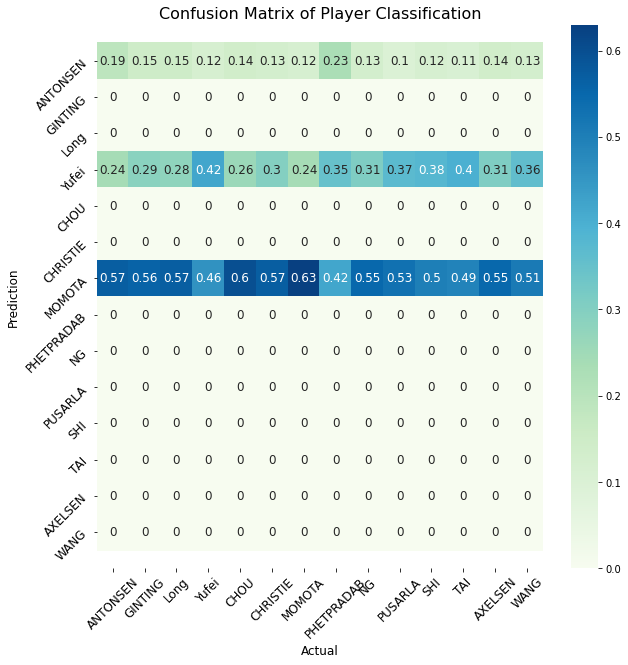

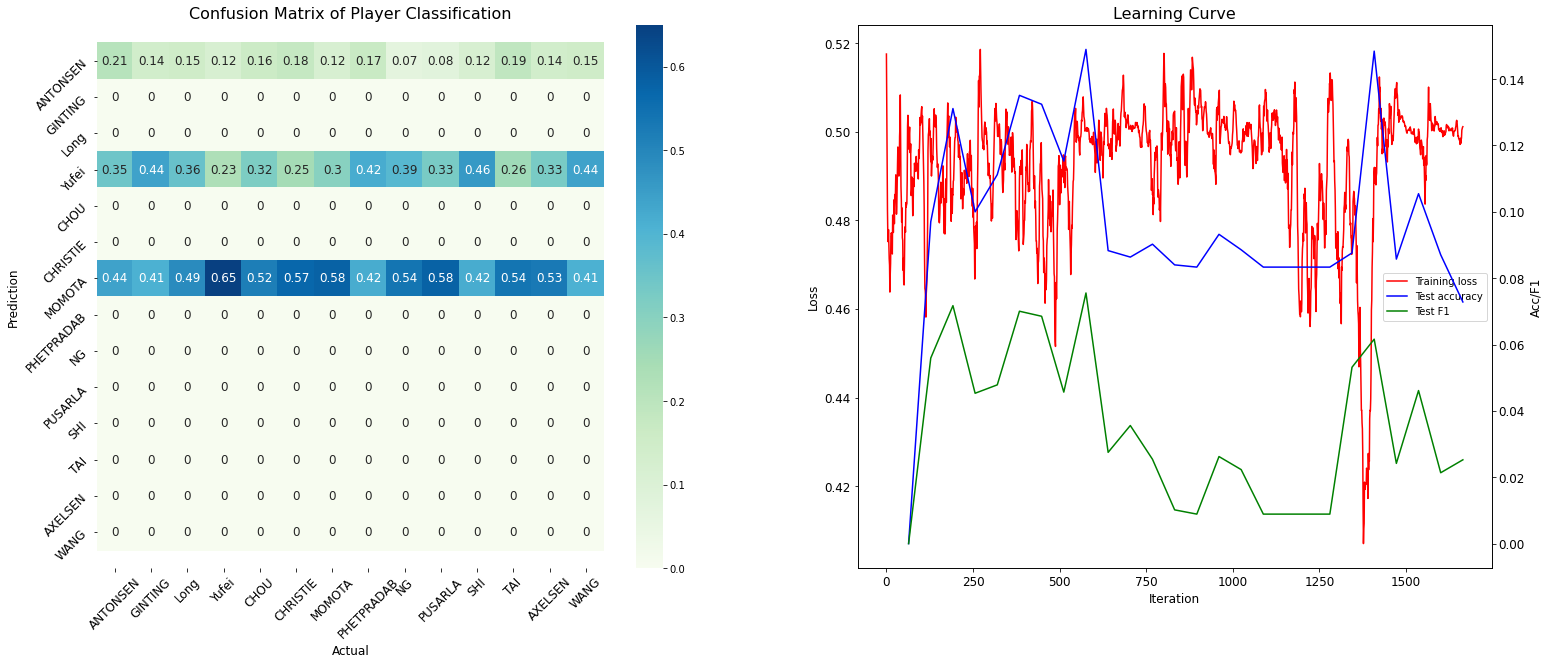

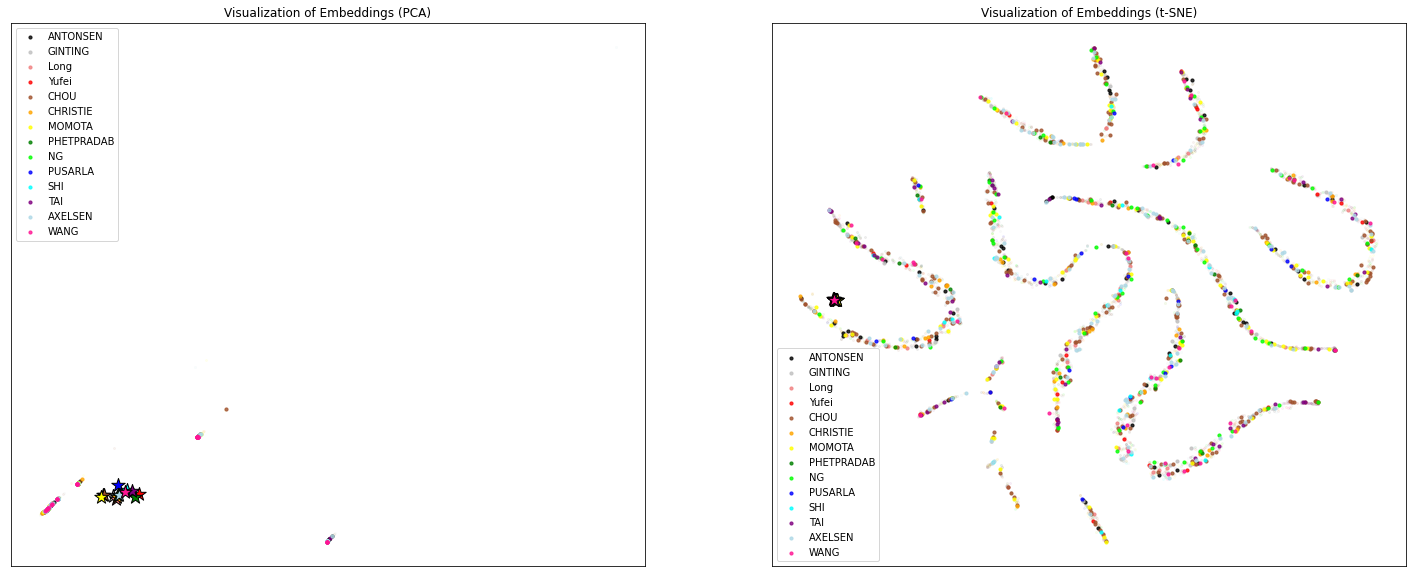

 10%|▉         | 49/500 [51:48<7:41:36, 61.41s/it] 

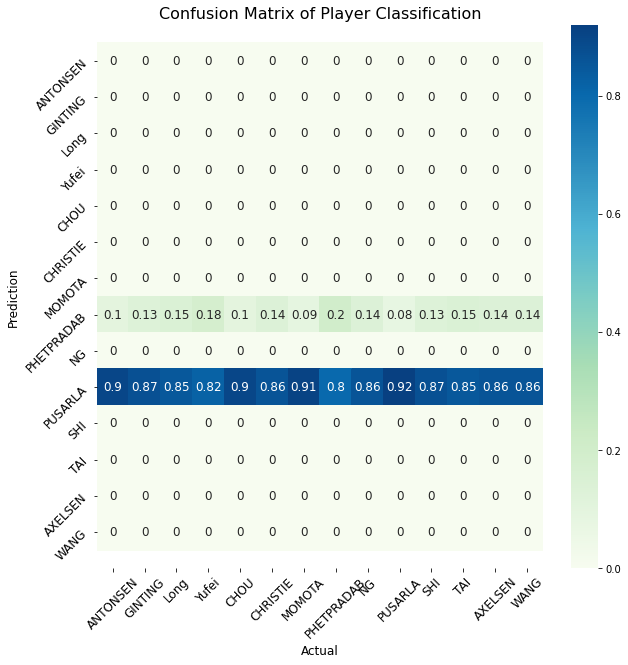

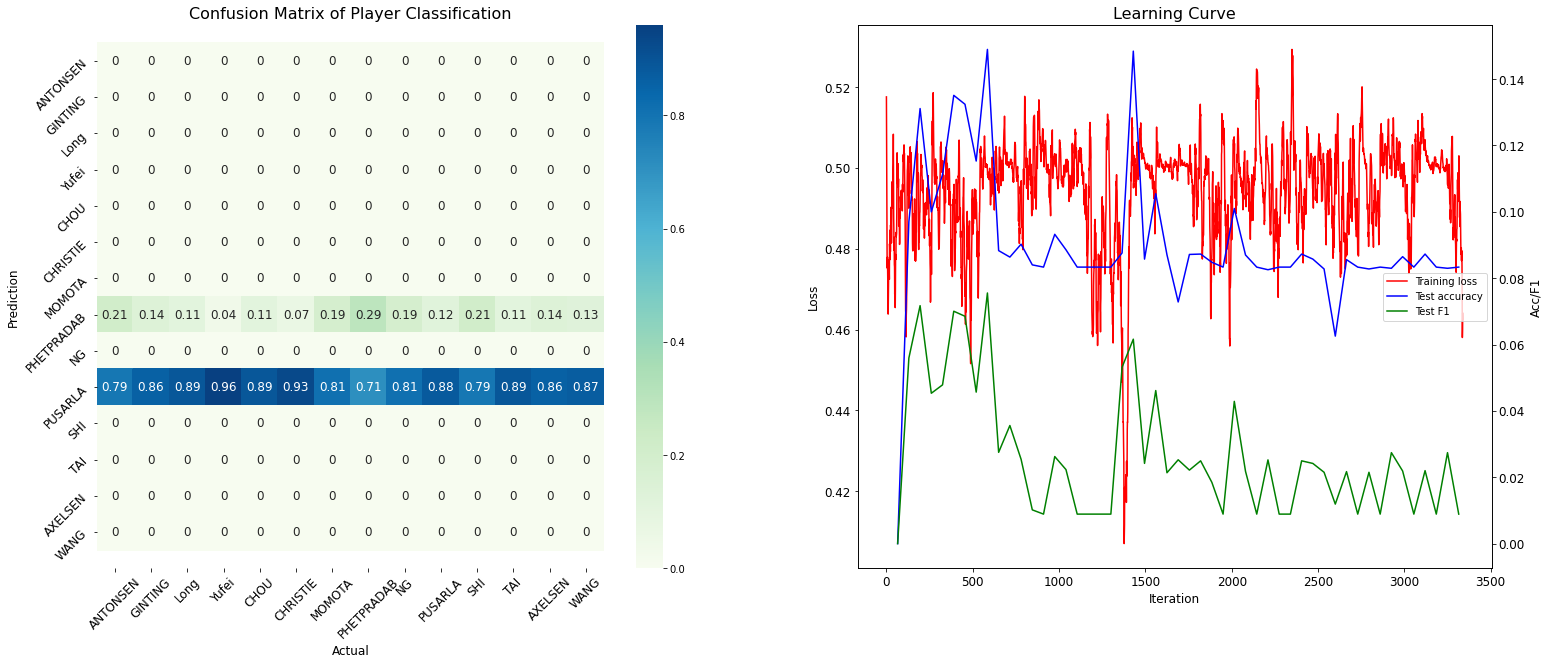

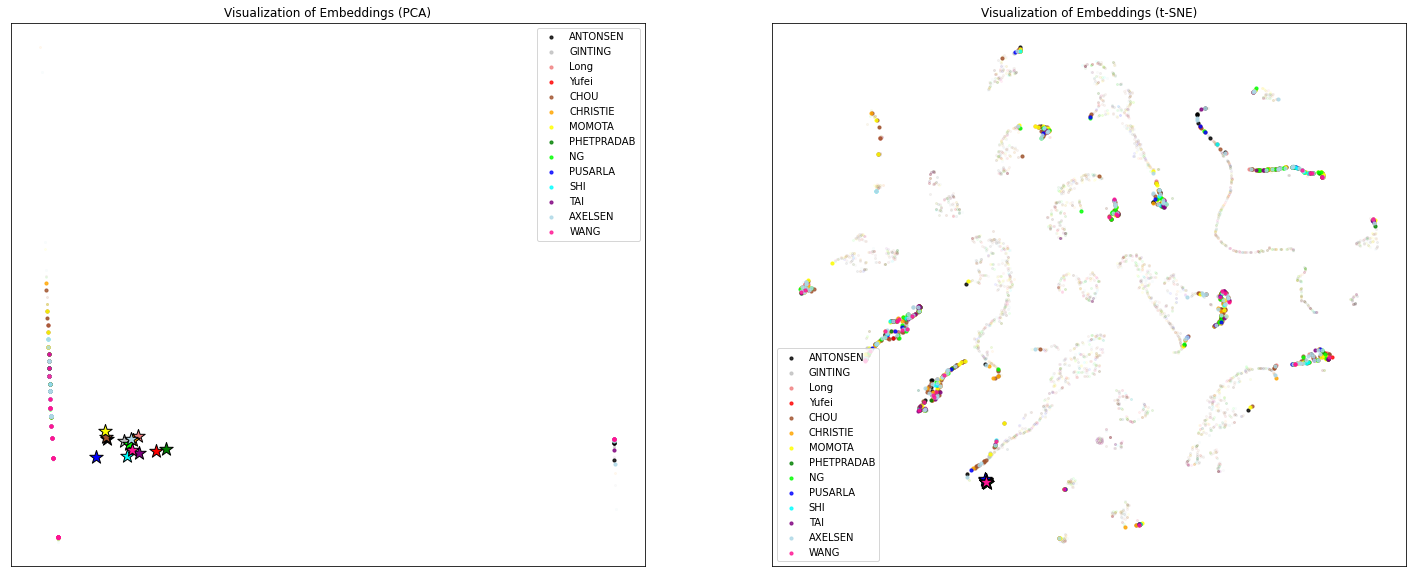

 15%|█▍        | 74/500 [1:19:05<7:12:57, 60.98s/it]

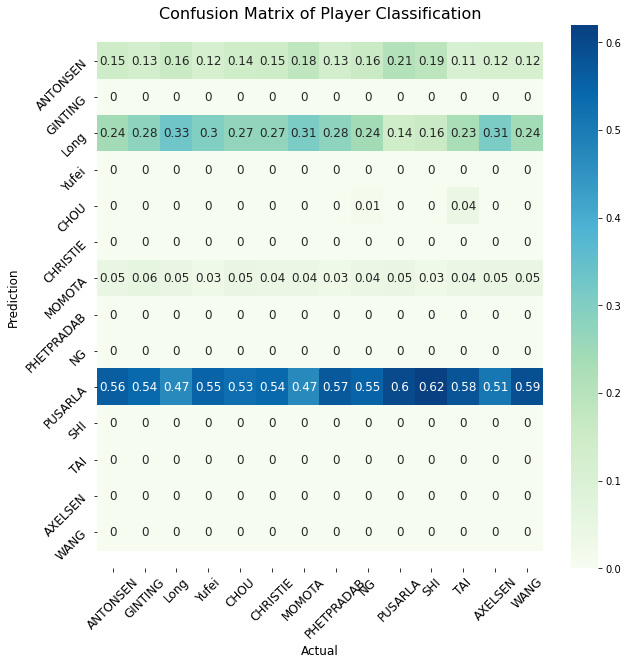

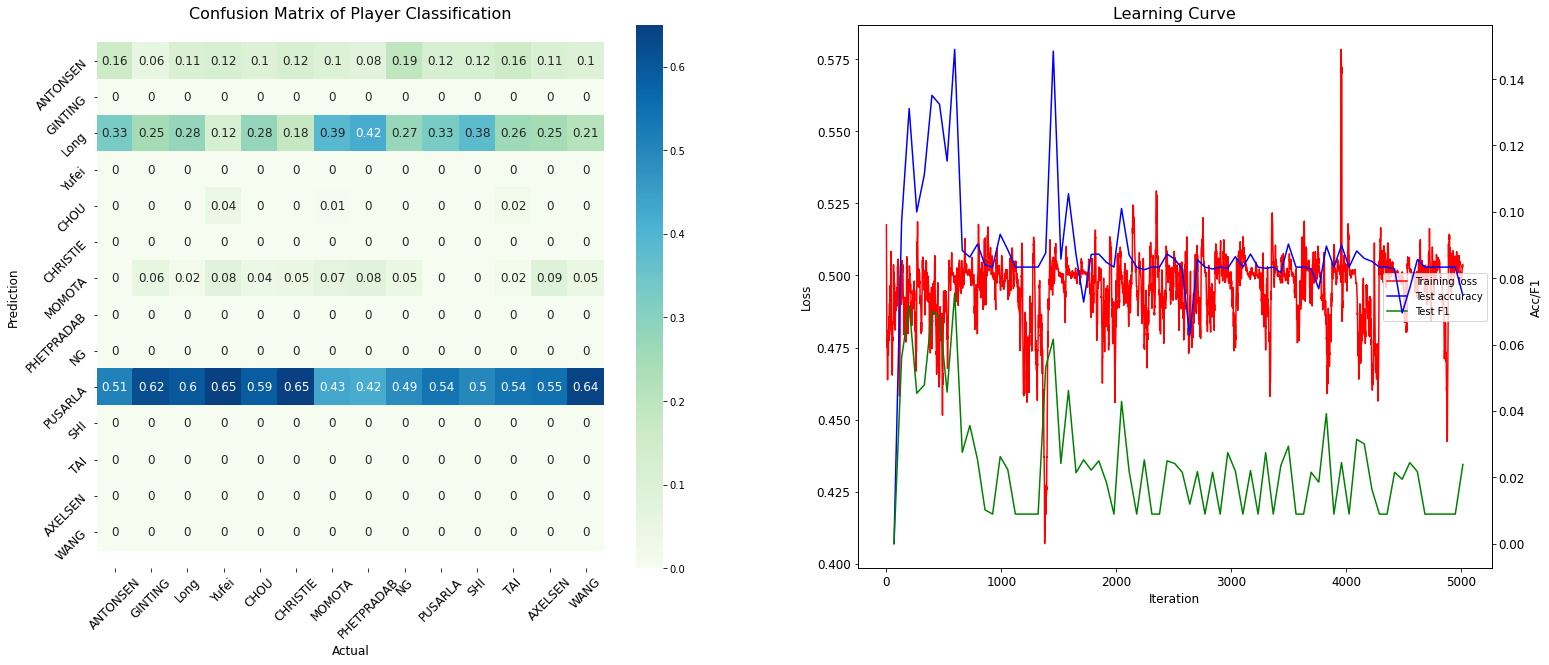

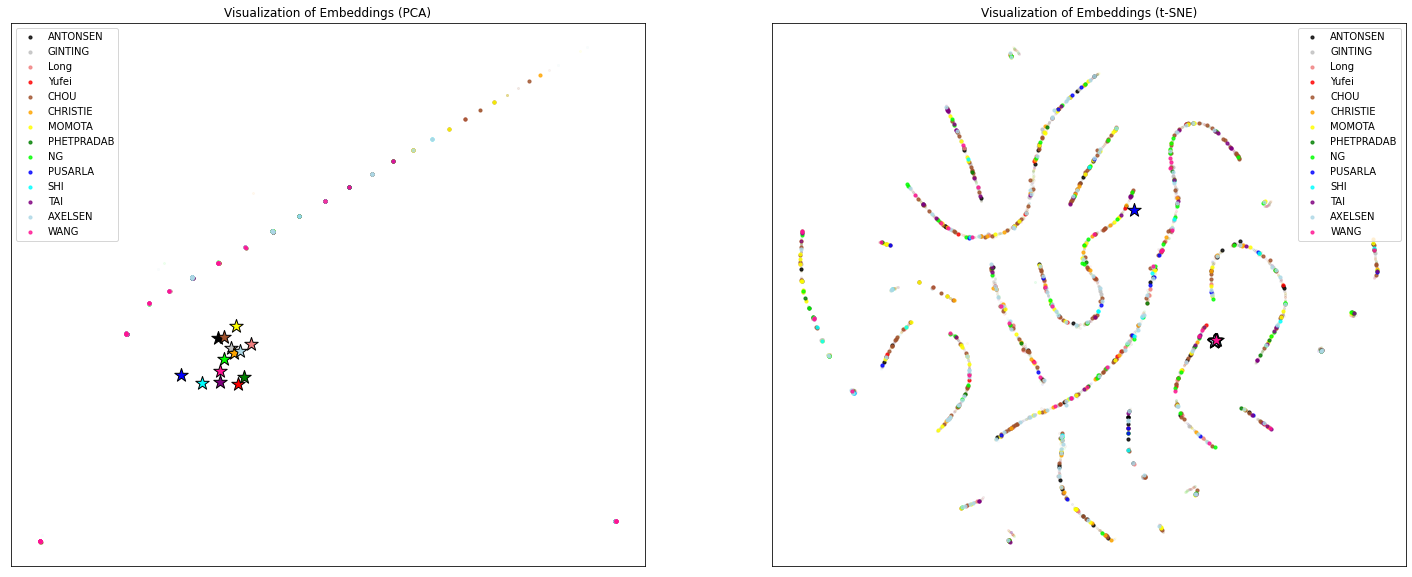

 20%|█▉        | 99/500 [1:46:14<6:46:01, 60.75s/it] 

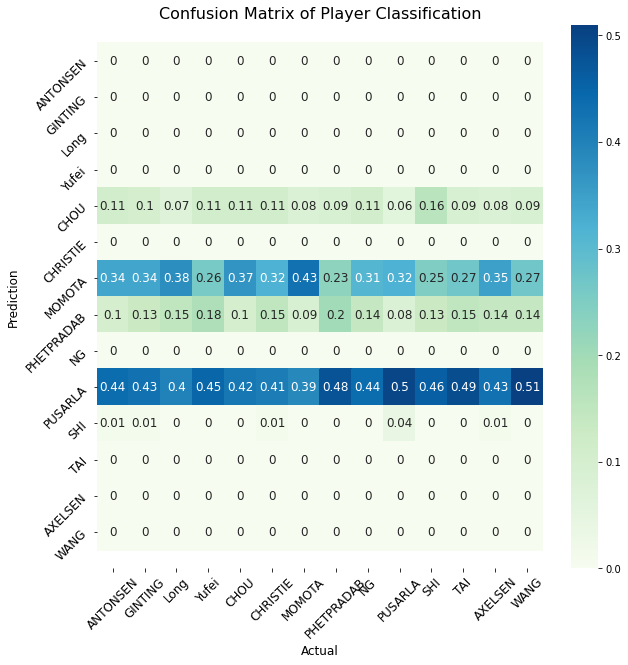

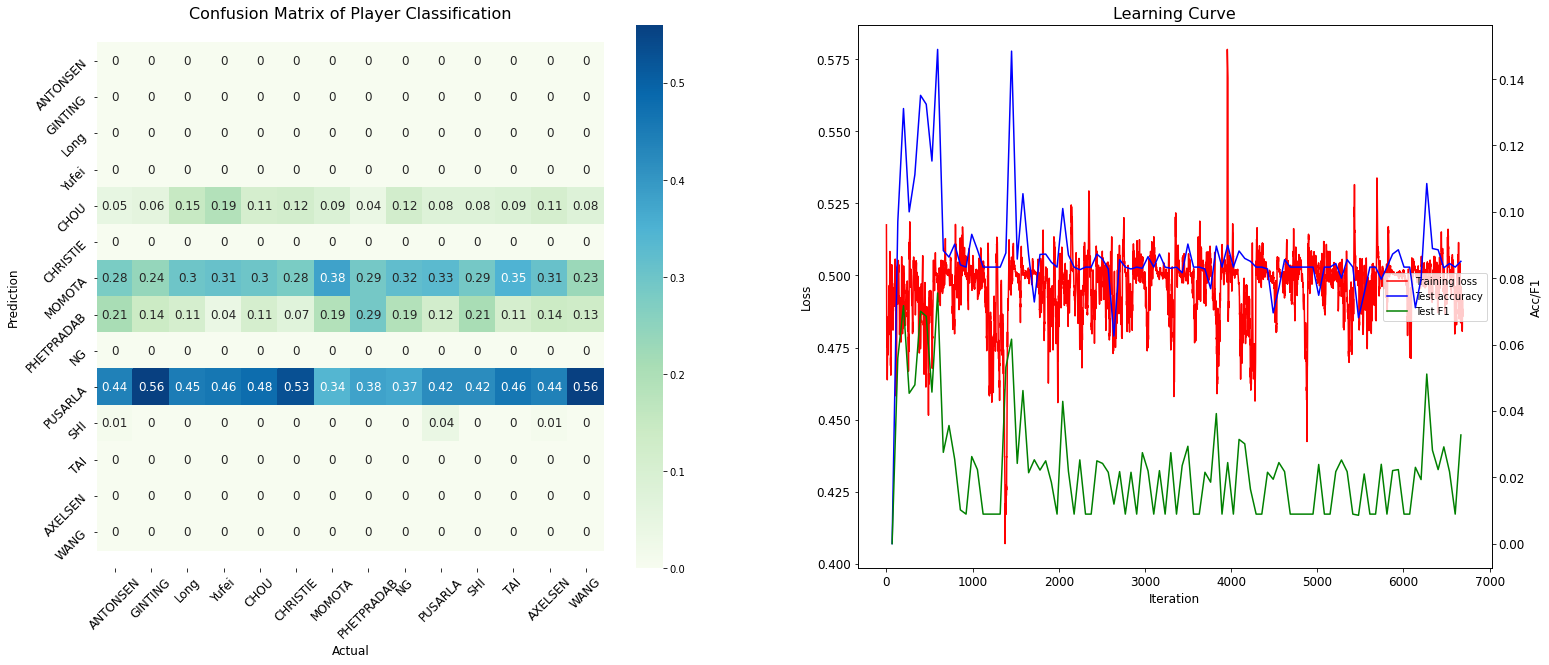

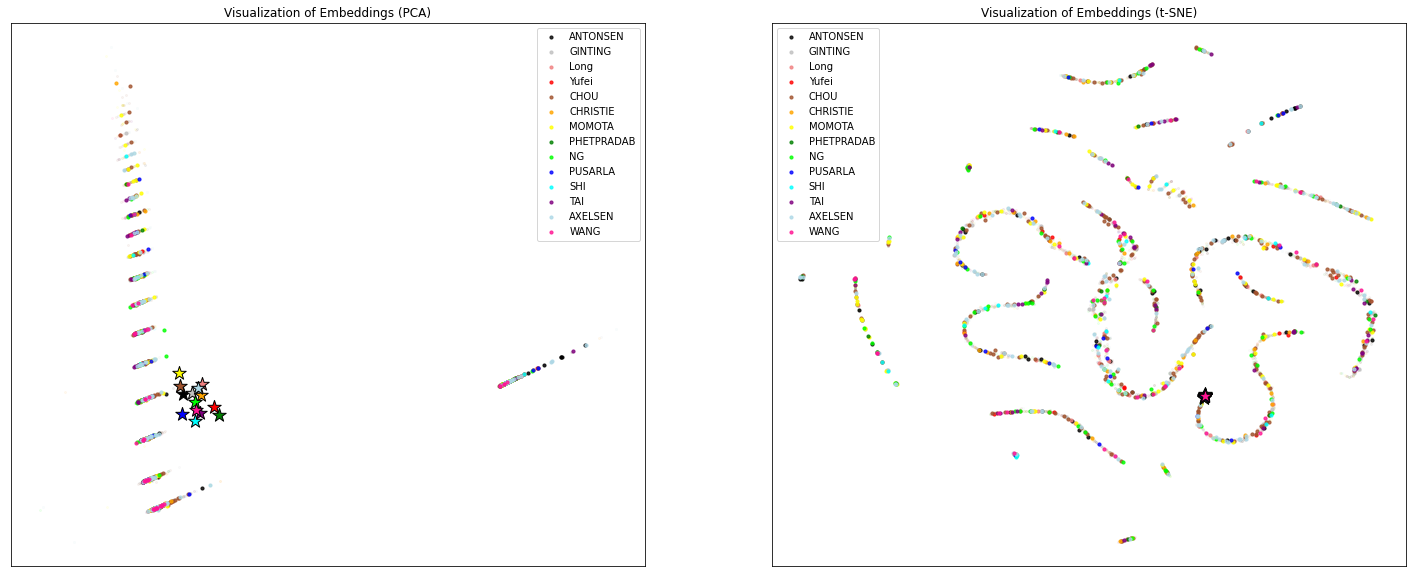

 25%|██▍       | 124/500 [2:13:24<6:21:47, 60.92s/it] 

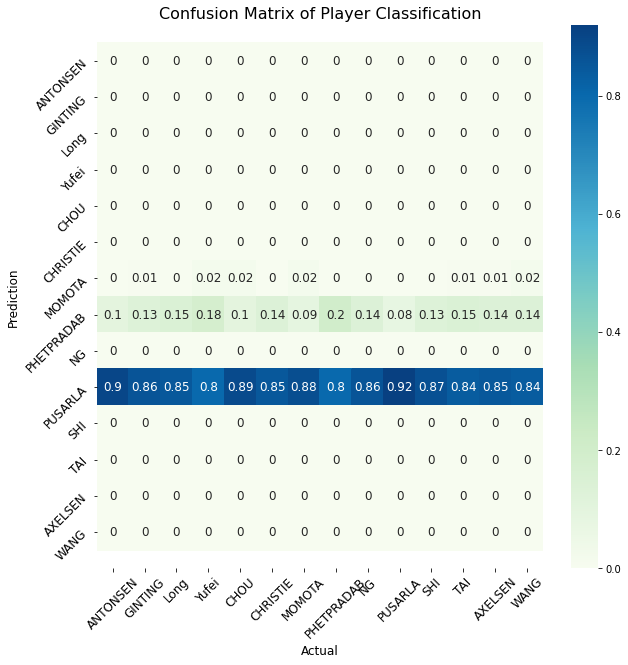

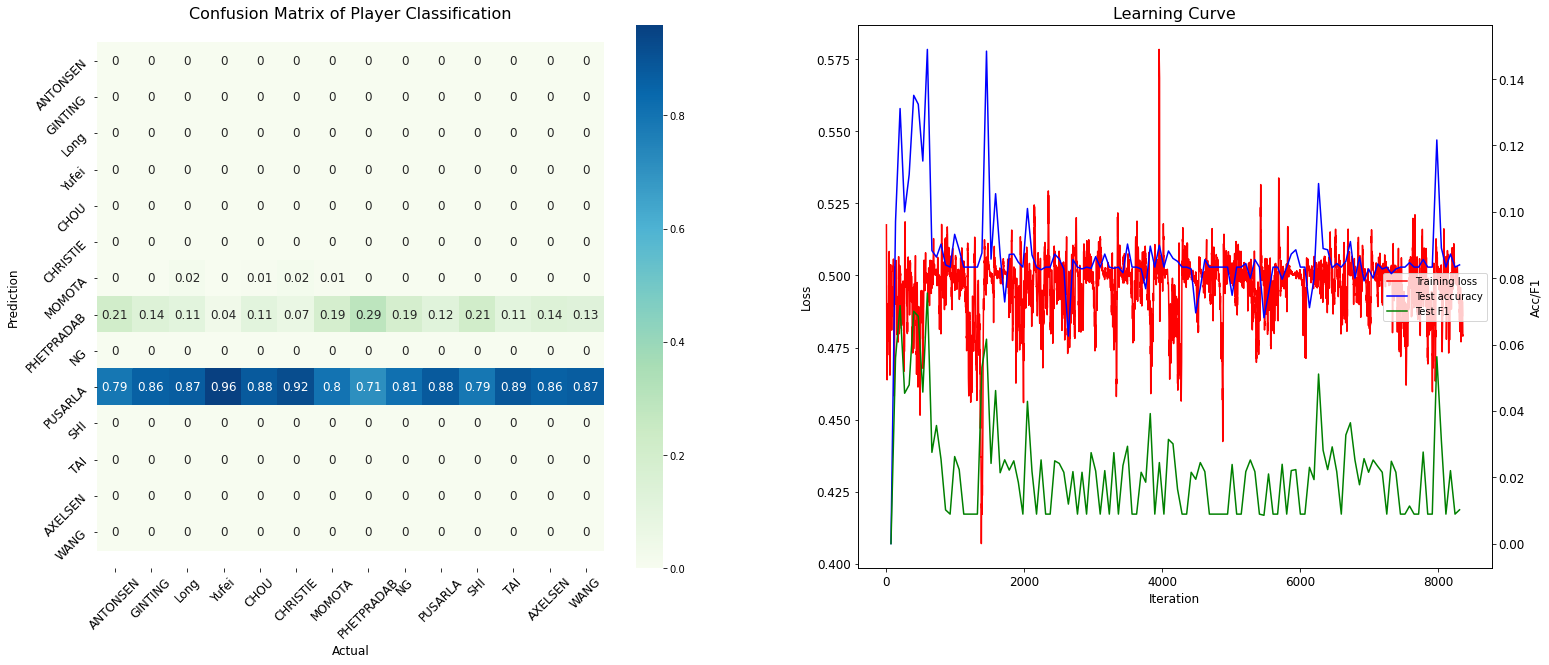

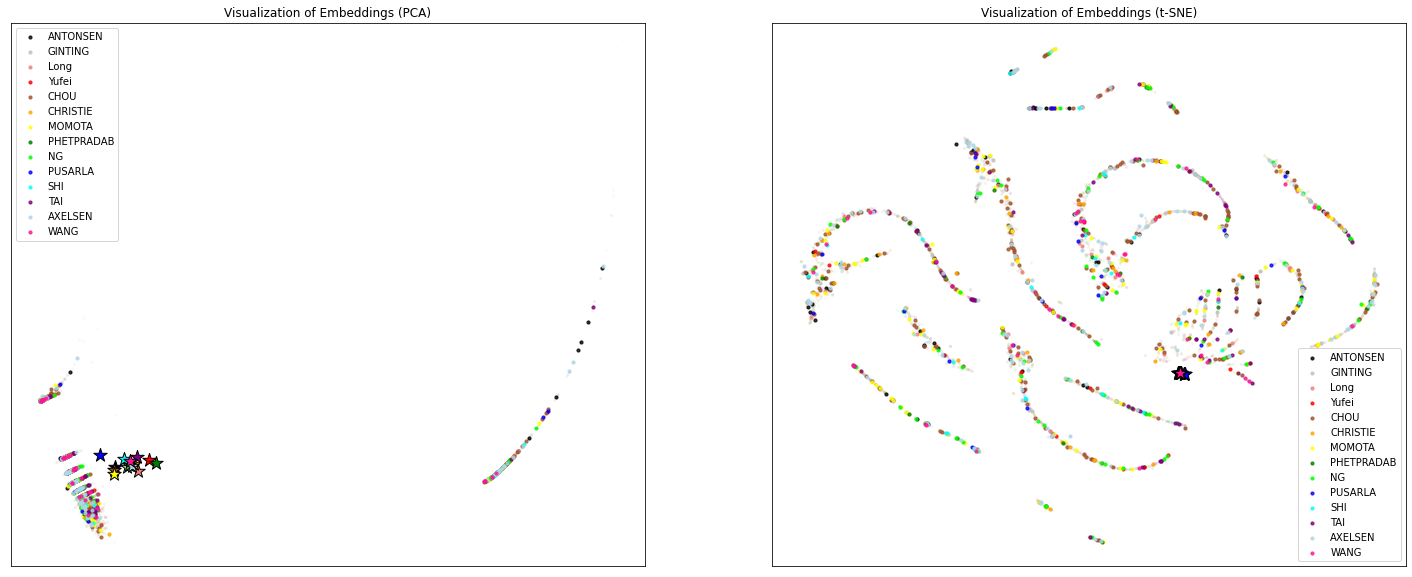

 30%|██▉       | 149/500 [2:40:39<5:57:46, 61.16s/it]

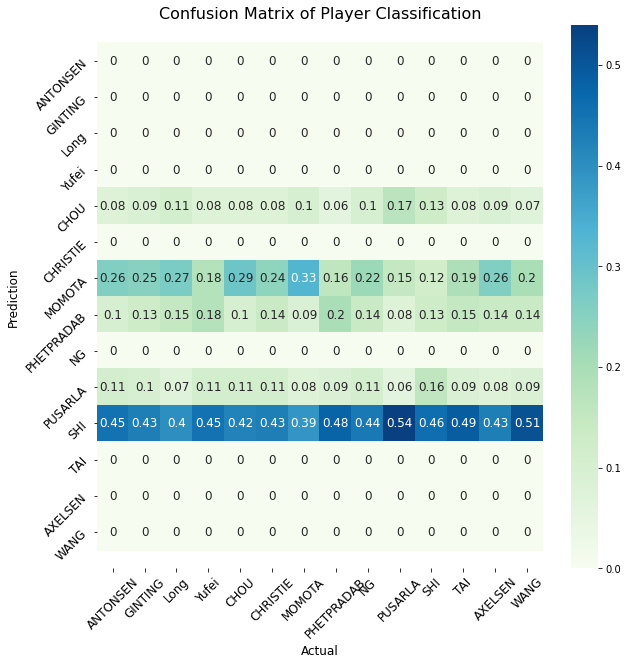

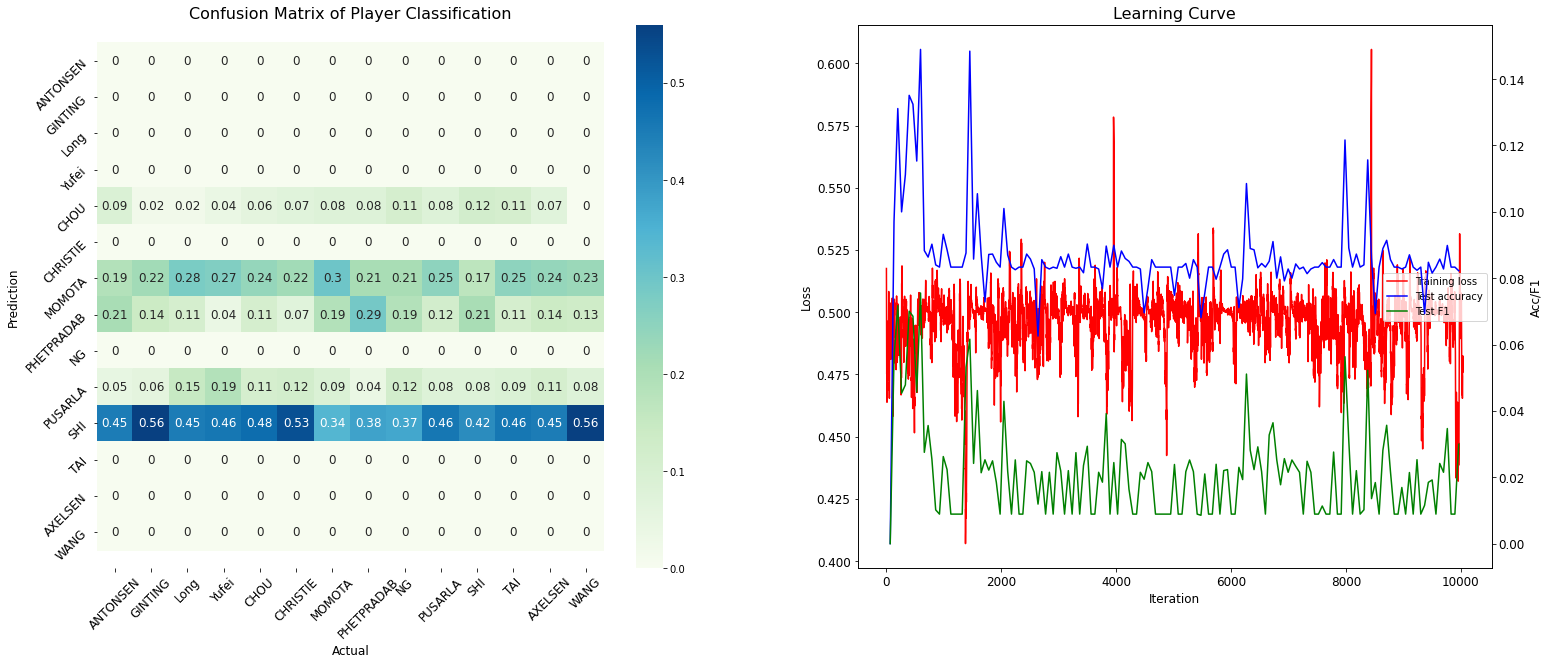

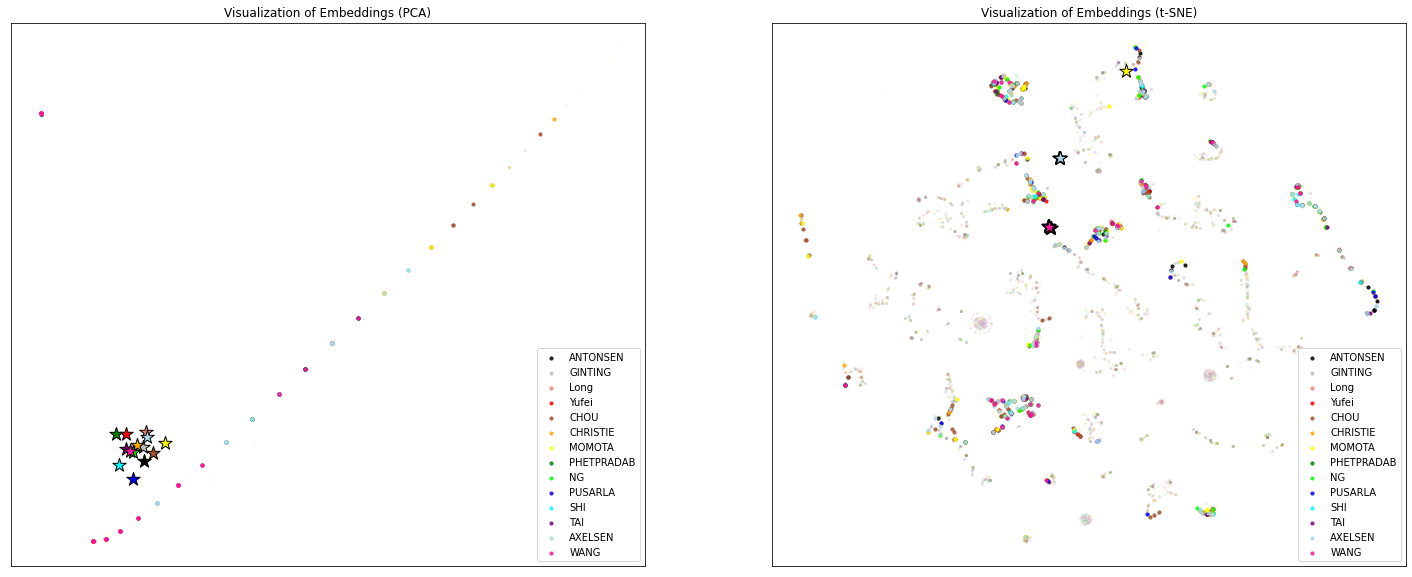

 35%|███▍      | 174/500 [3:07:54<5:33:35, 61.40s/it]

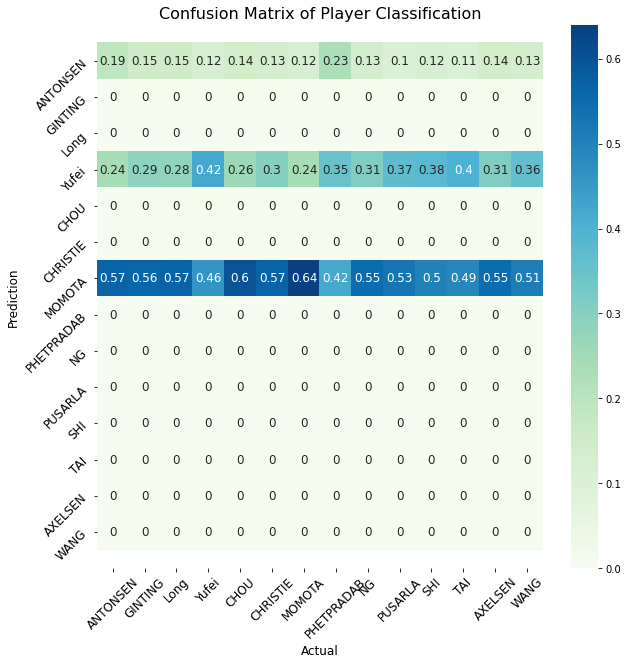

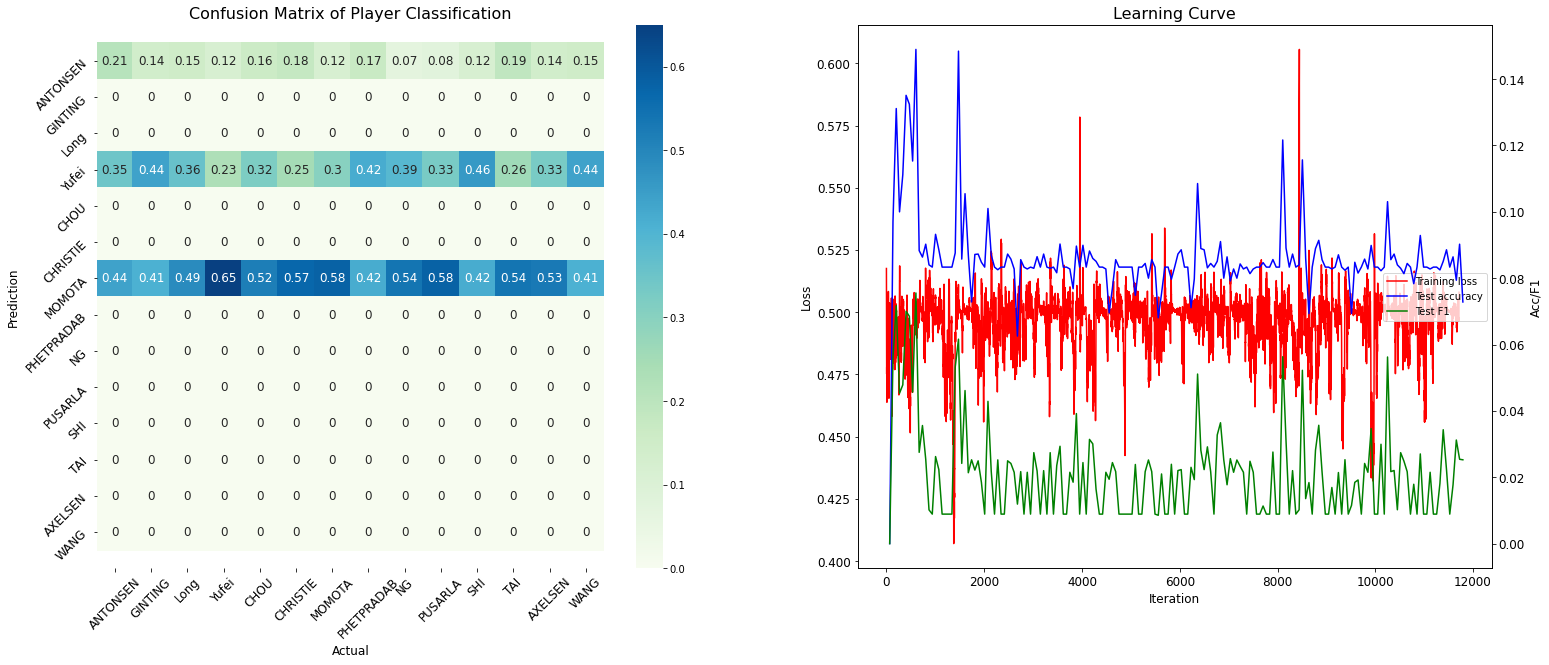

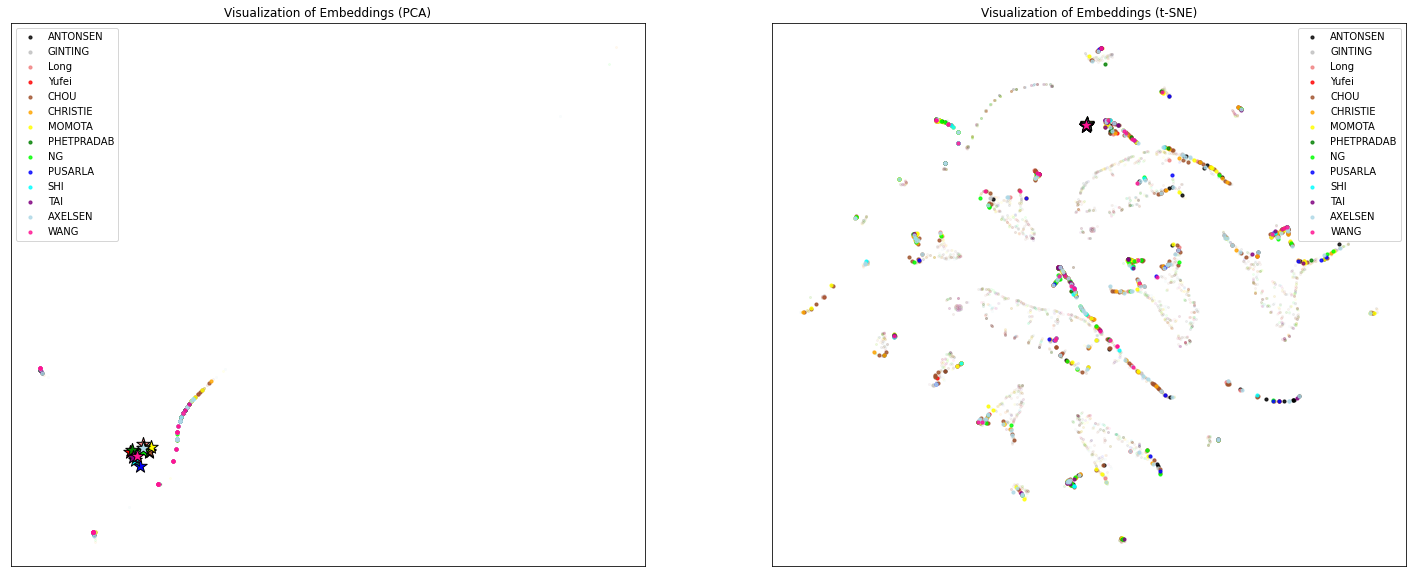

 40%|███▉      | 199/500 [3:35:05<5:04:25, 60.68s/it]

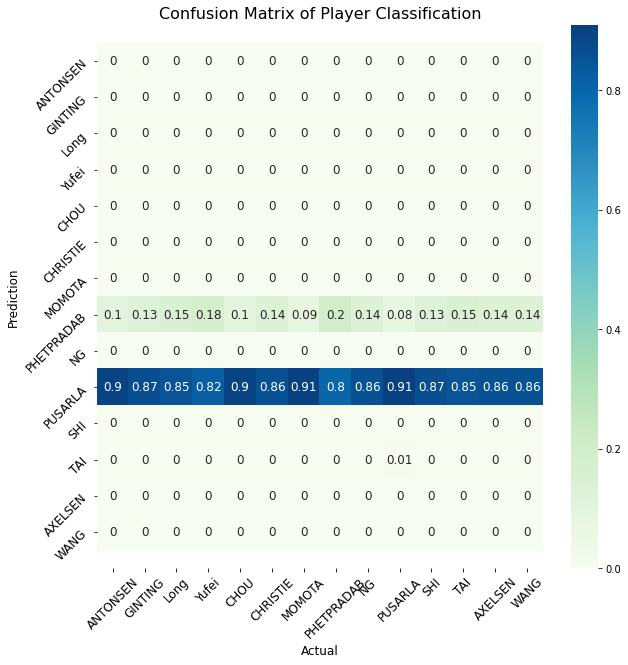

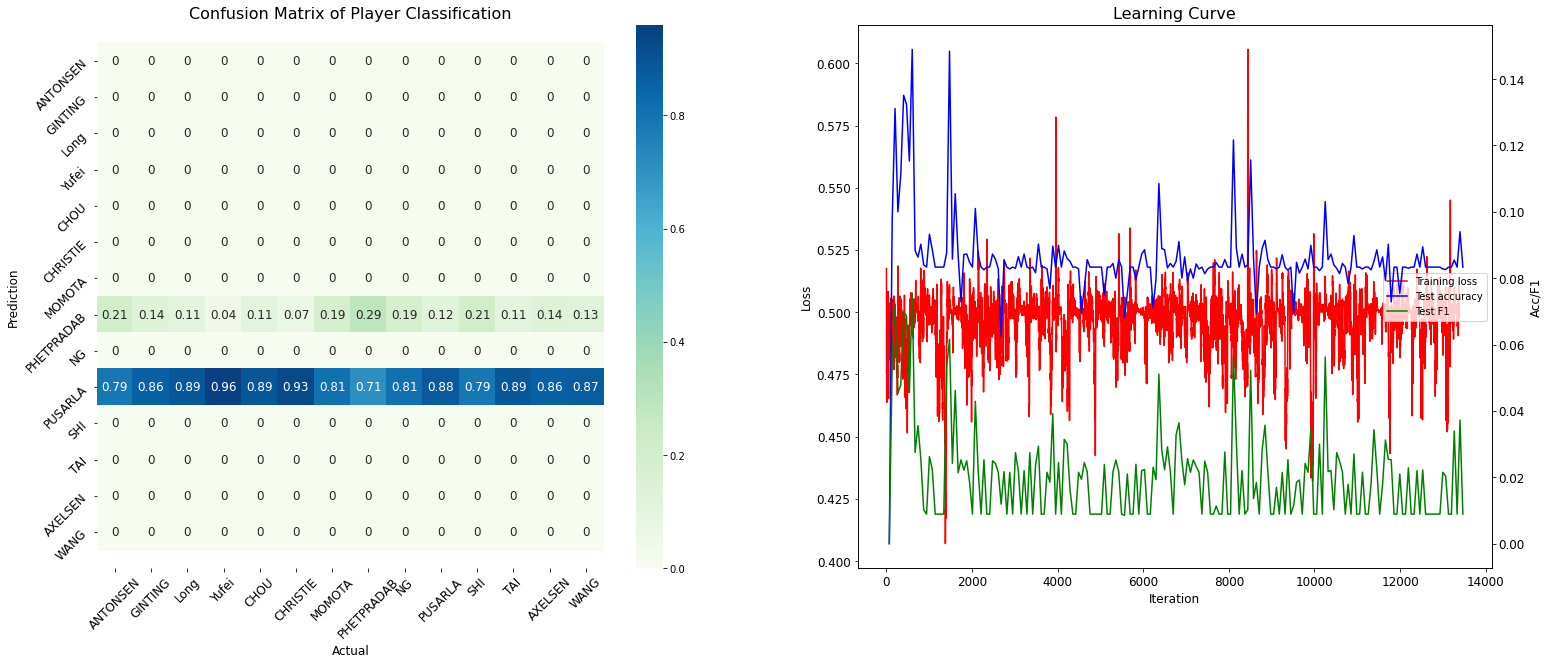

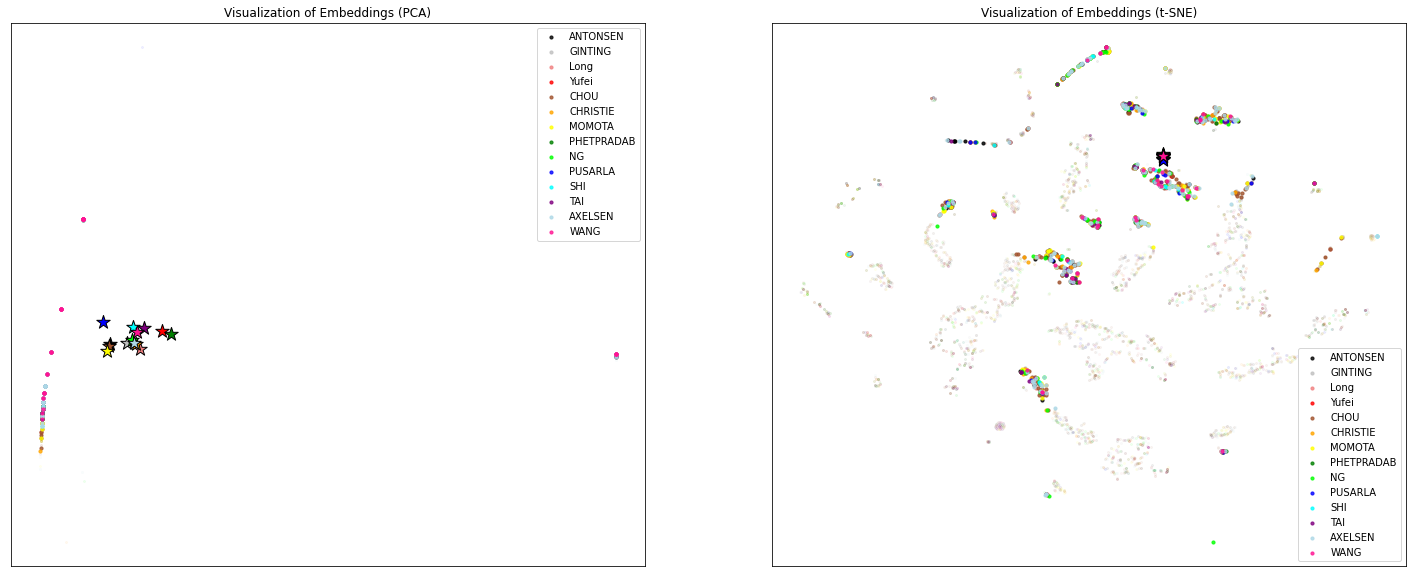

 45%|████▍     | 224/500 [4:02:18<4:42:13, 61.35s/it]

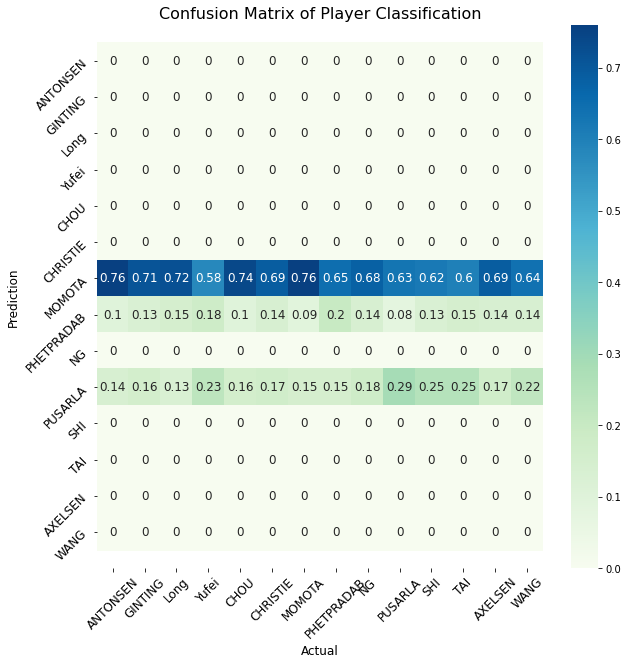

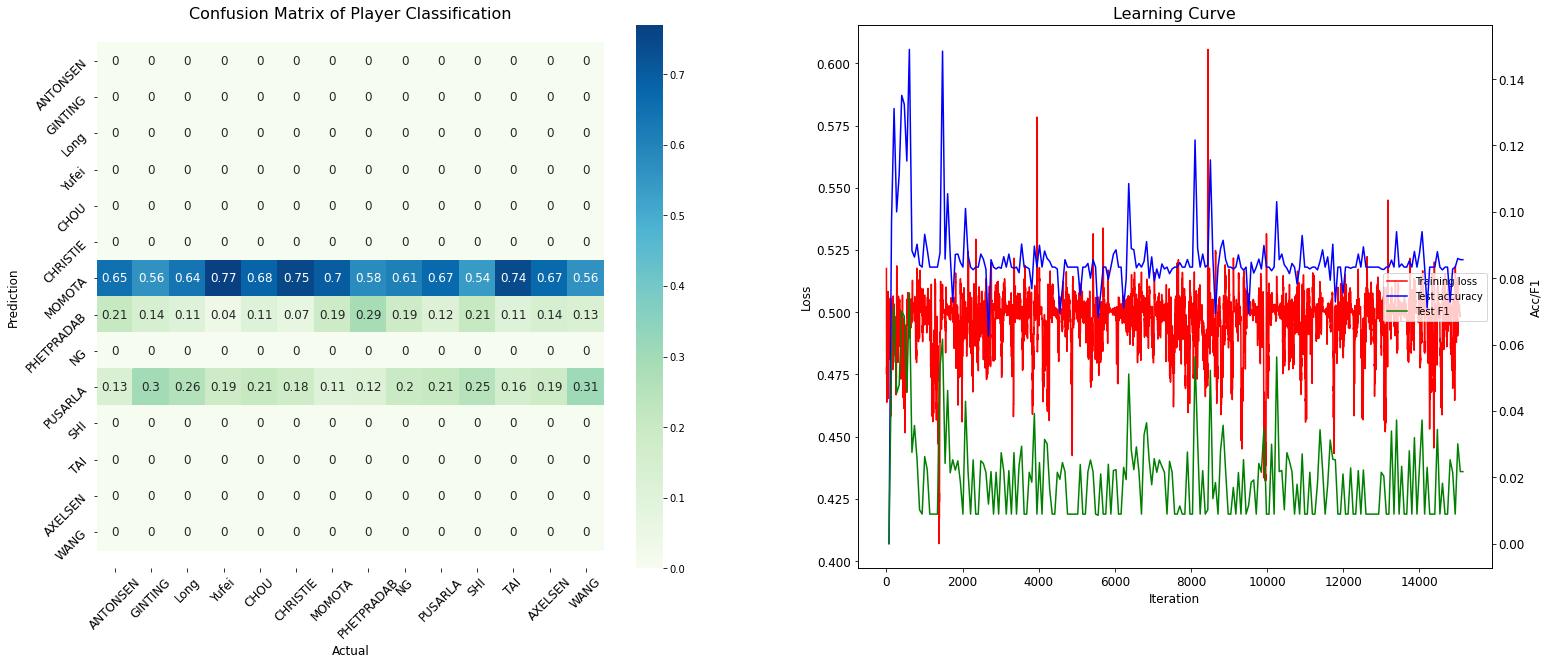

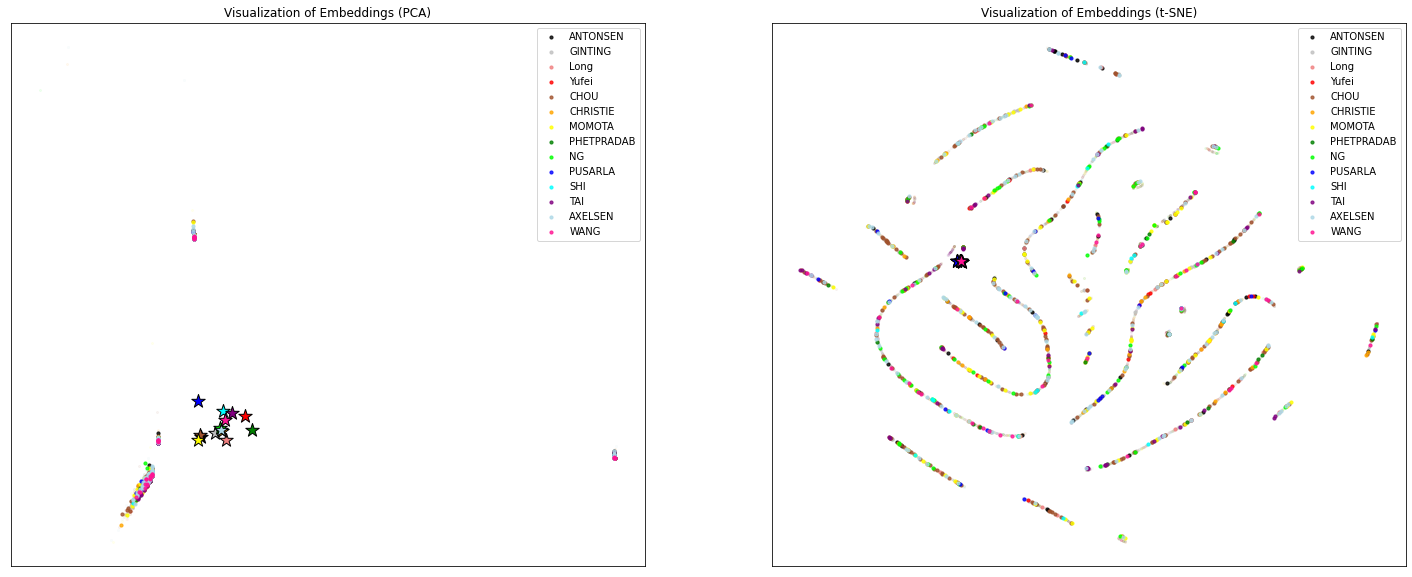

 50%|████▉     | 249/500 [4:29:32<4:15:28, 61.07s/it]

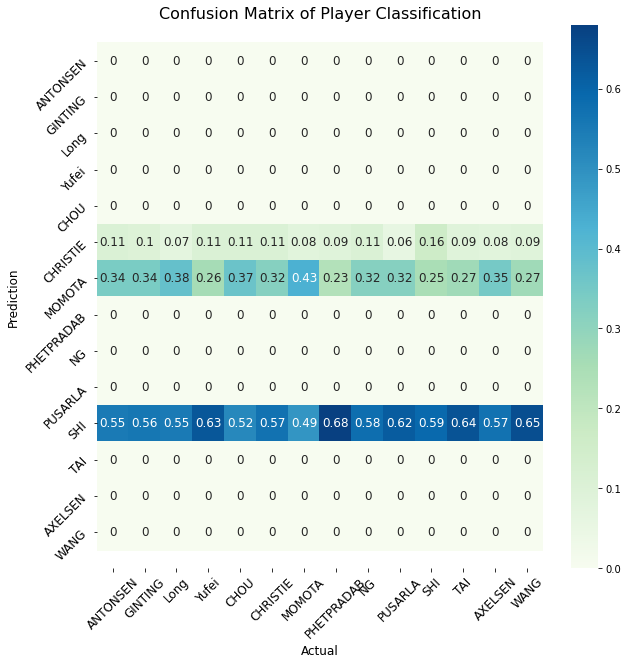

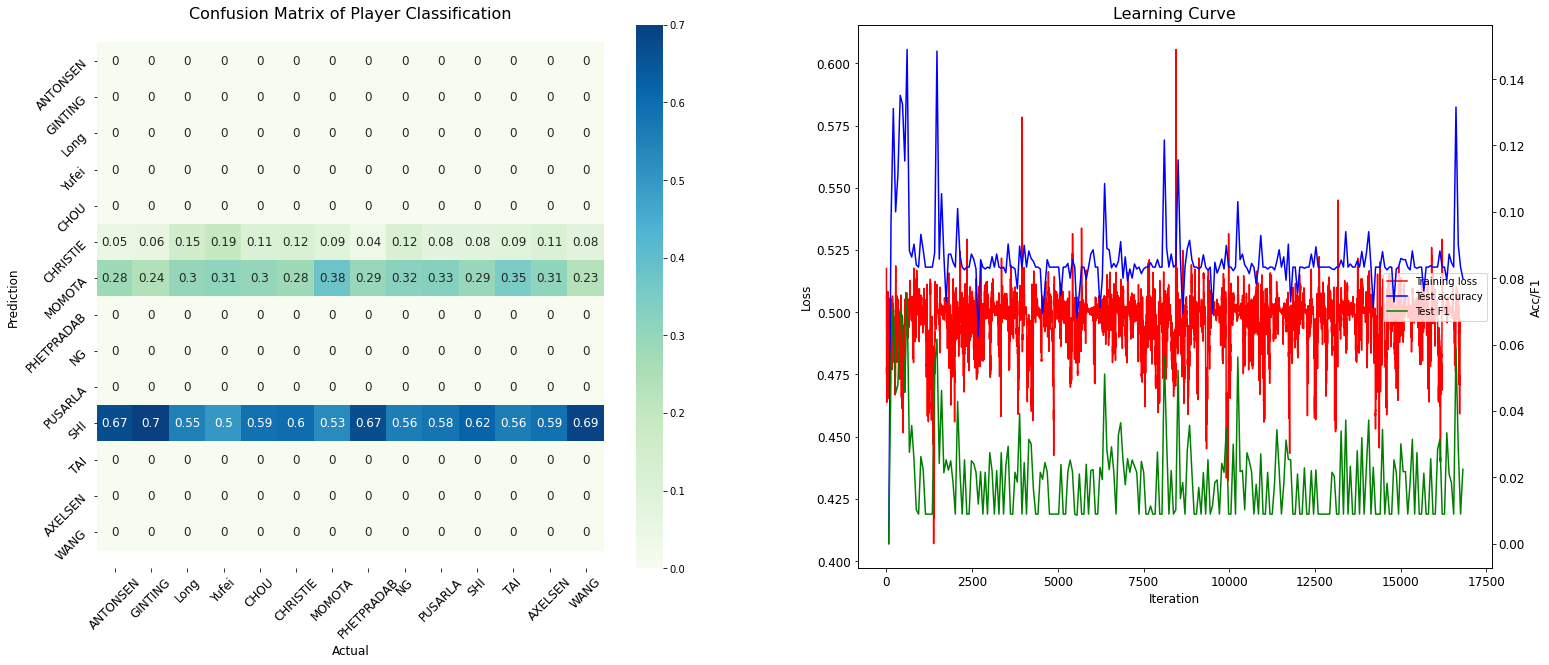

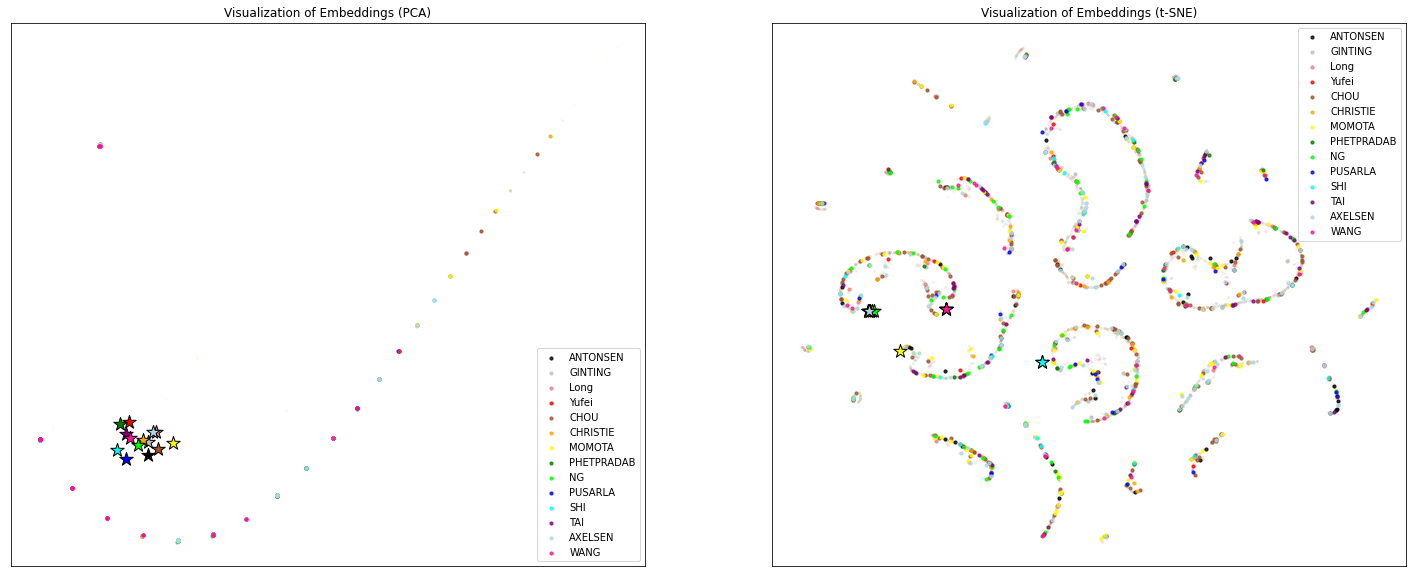

 55%|█████▍    | 274/500 [4:56:53<3:51:00, 61.33s/it]

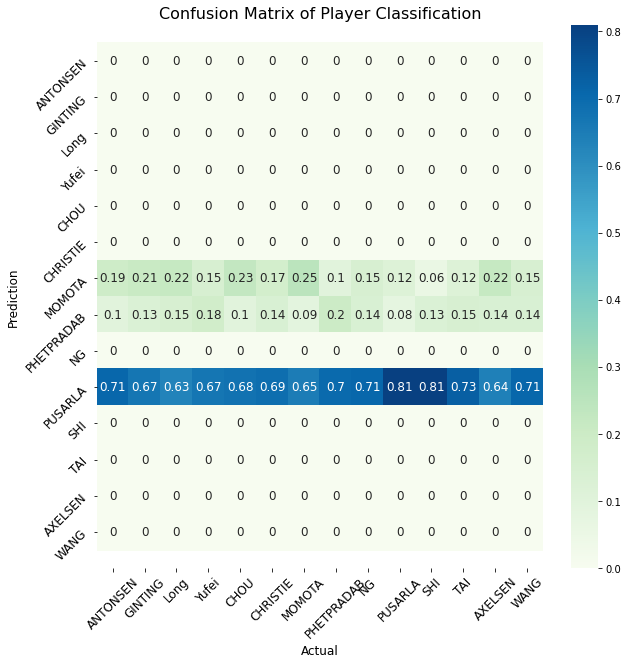

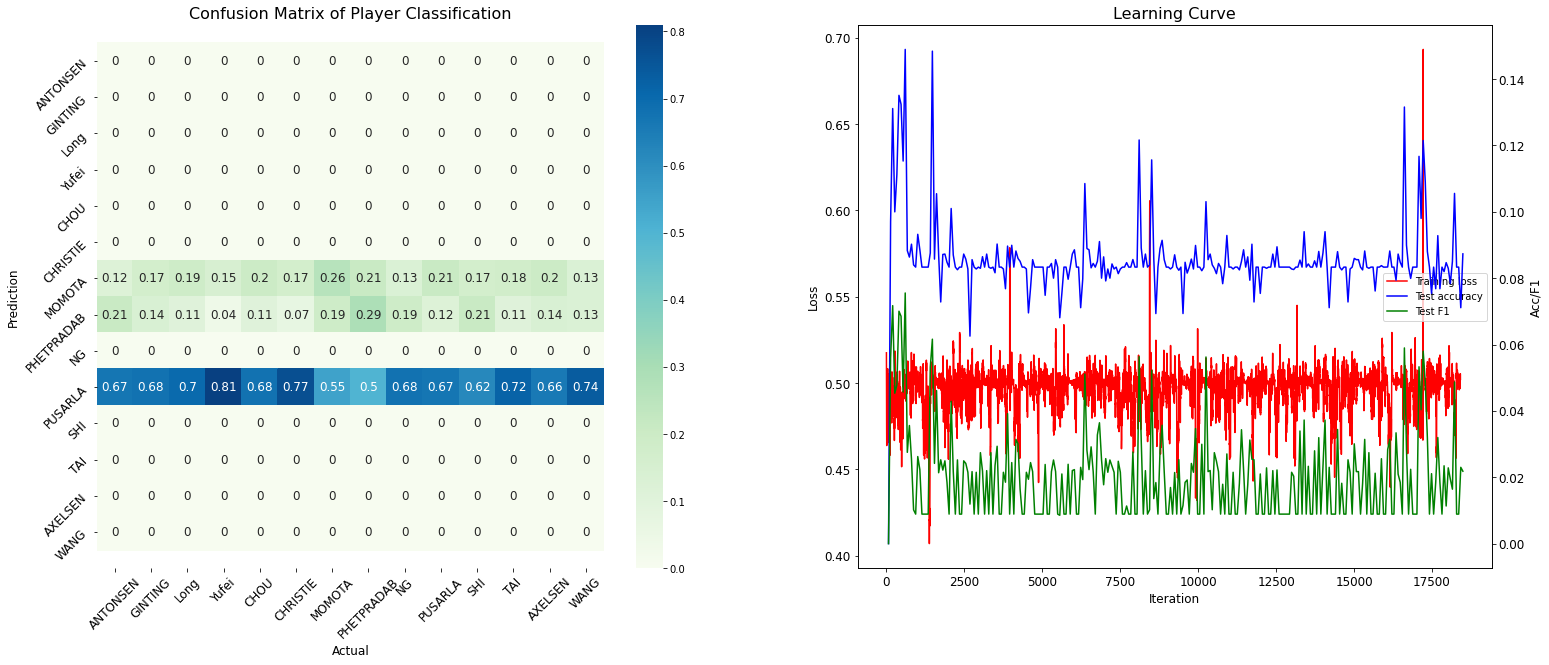

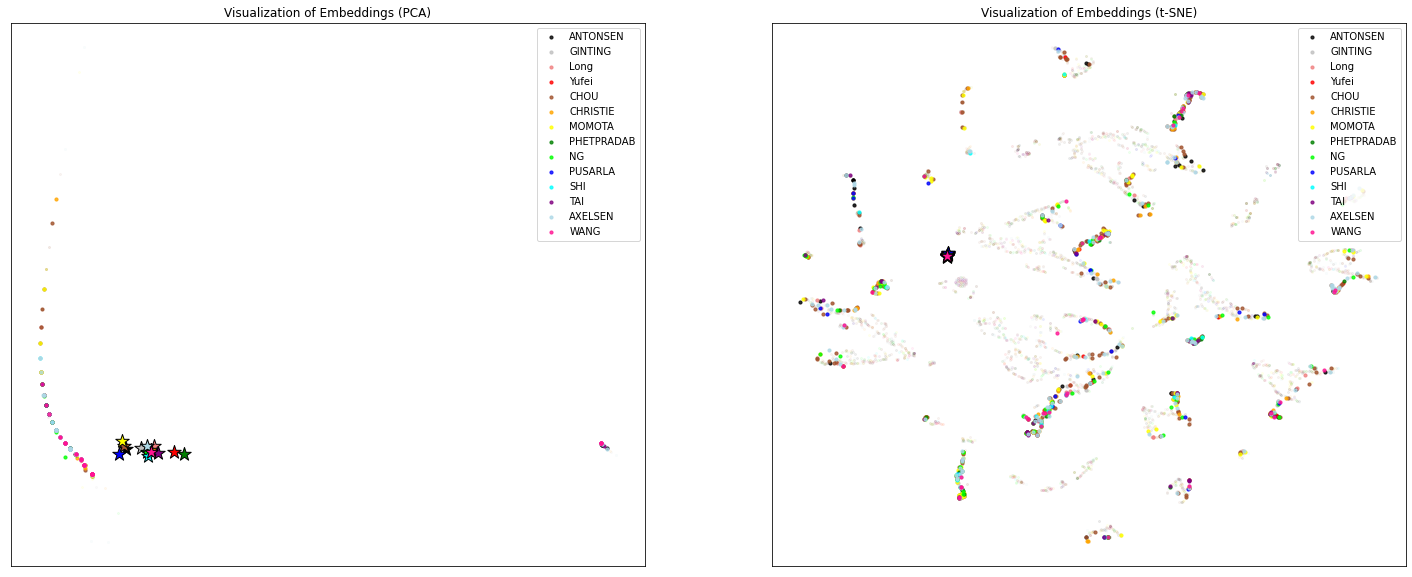

 60%|█████▉    | 299/500 [5:24:09<3:25:18, 61.29s/it]

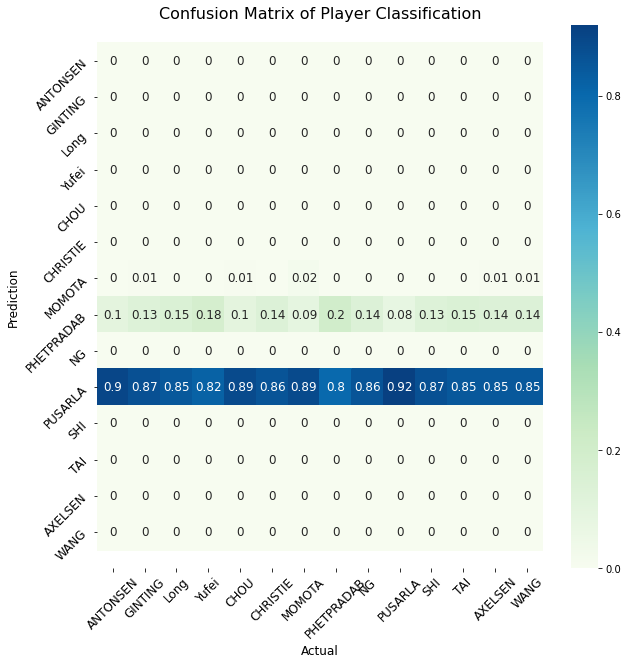

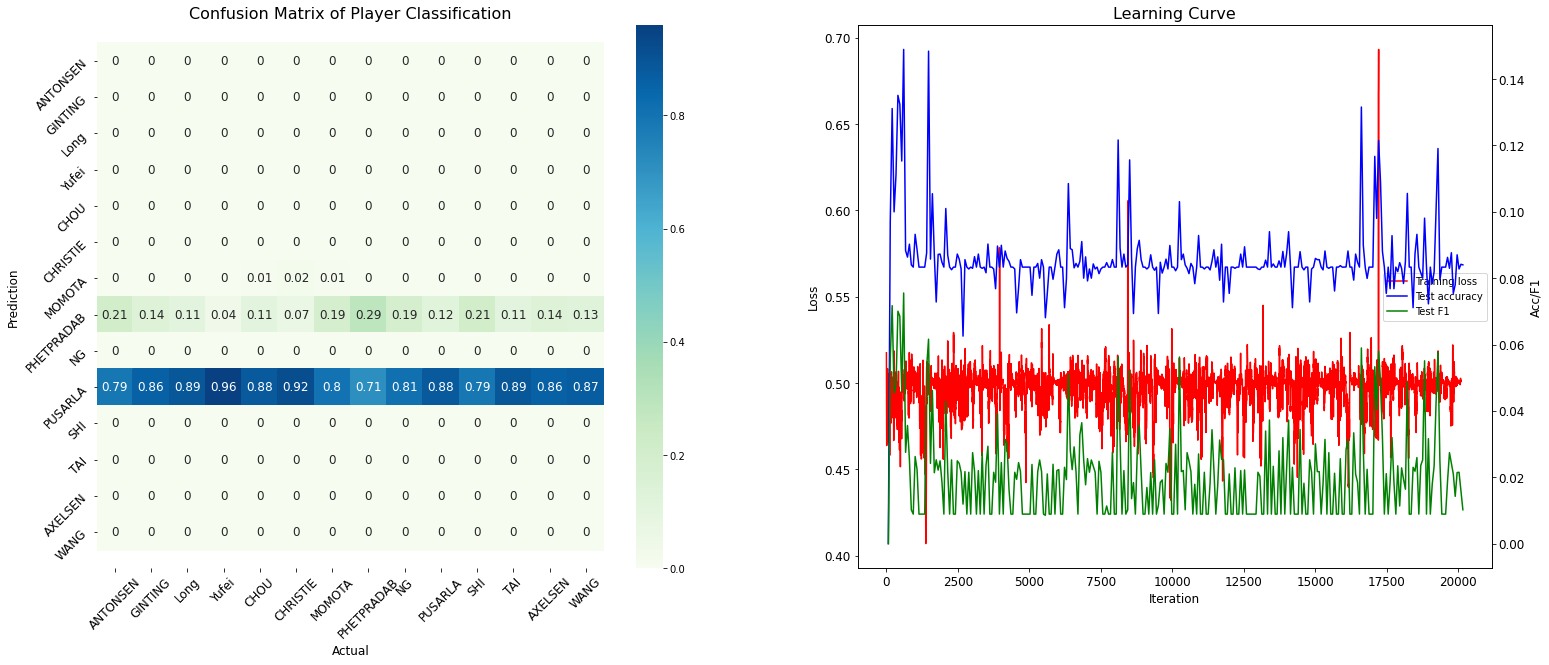

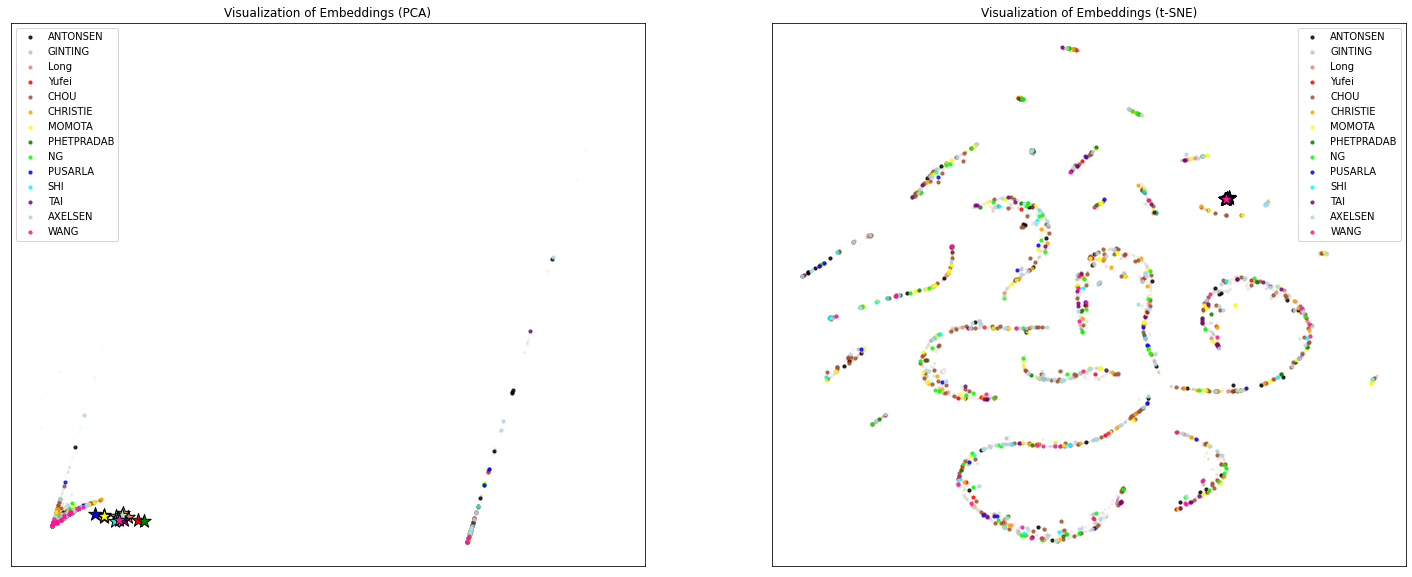

 65%|██████▍   | 324/500 [5:51:23<3:00:36, 61.57s/it]

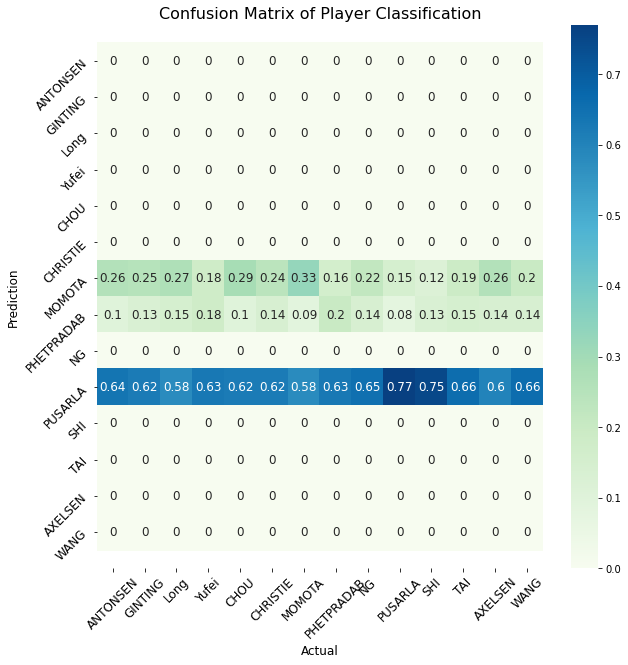

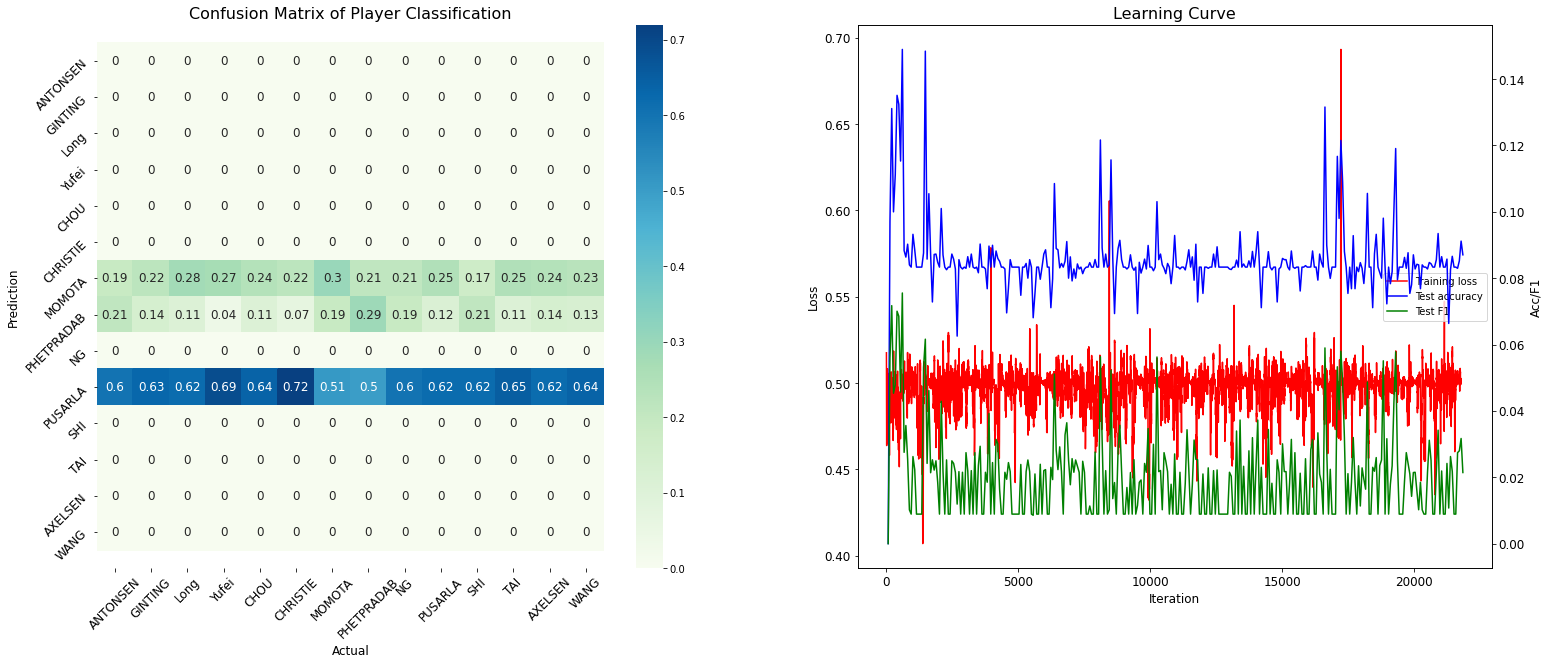

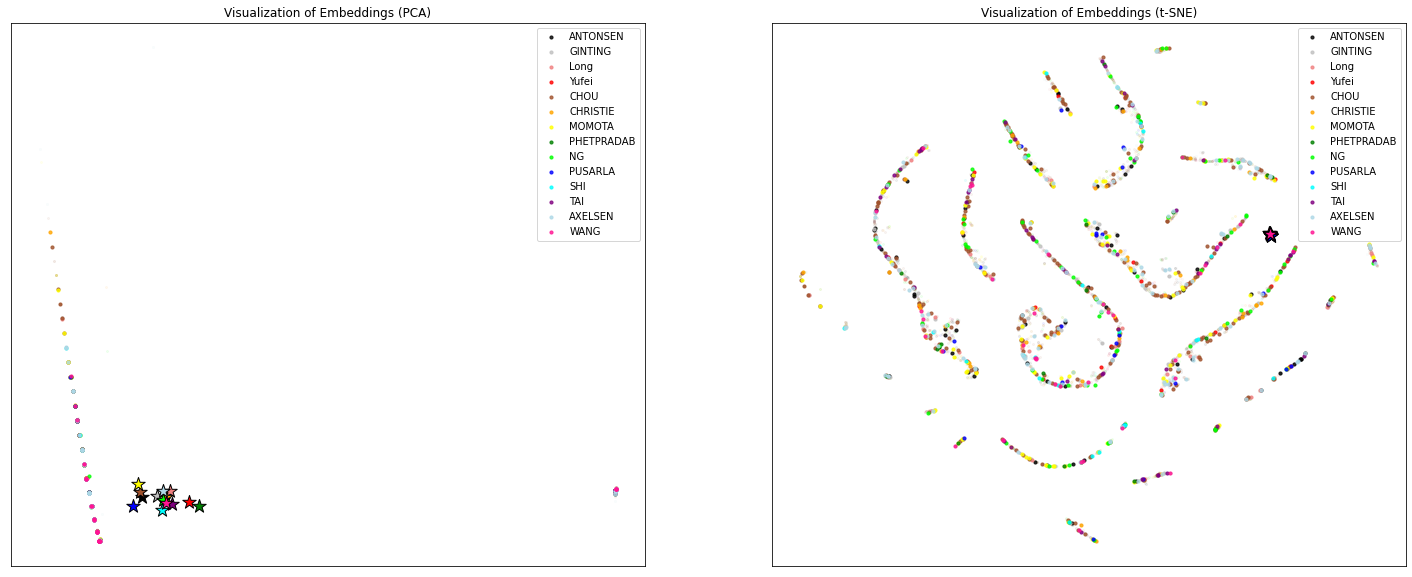

 70%|██████▉   | 349/500 [6:18:37<2:34:05, 61.23s/it]

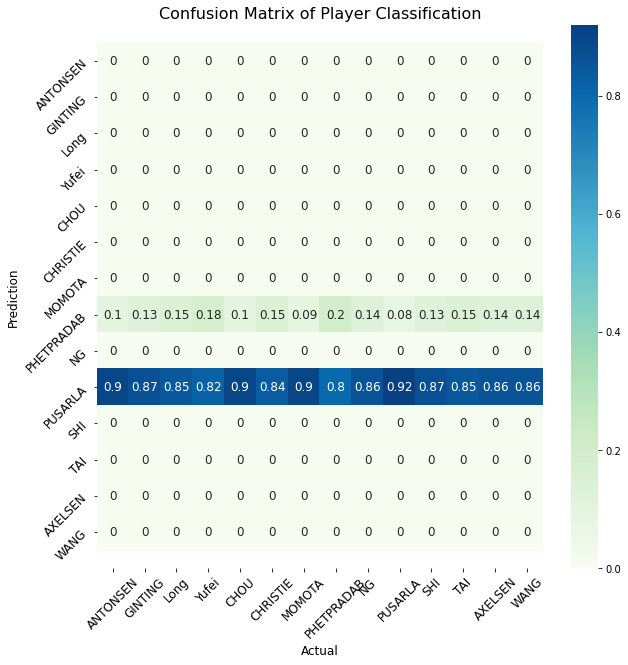

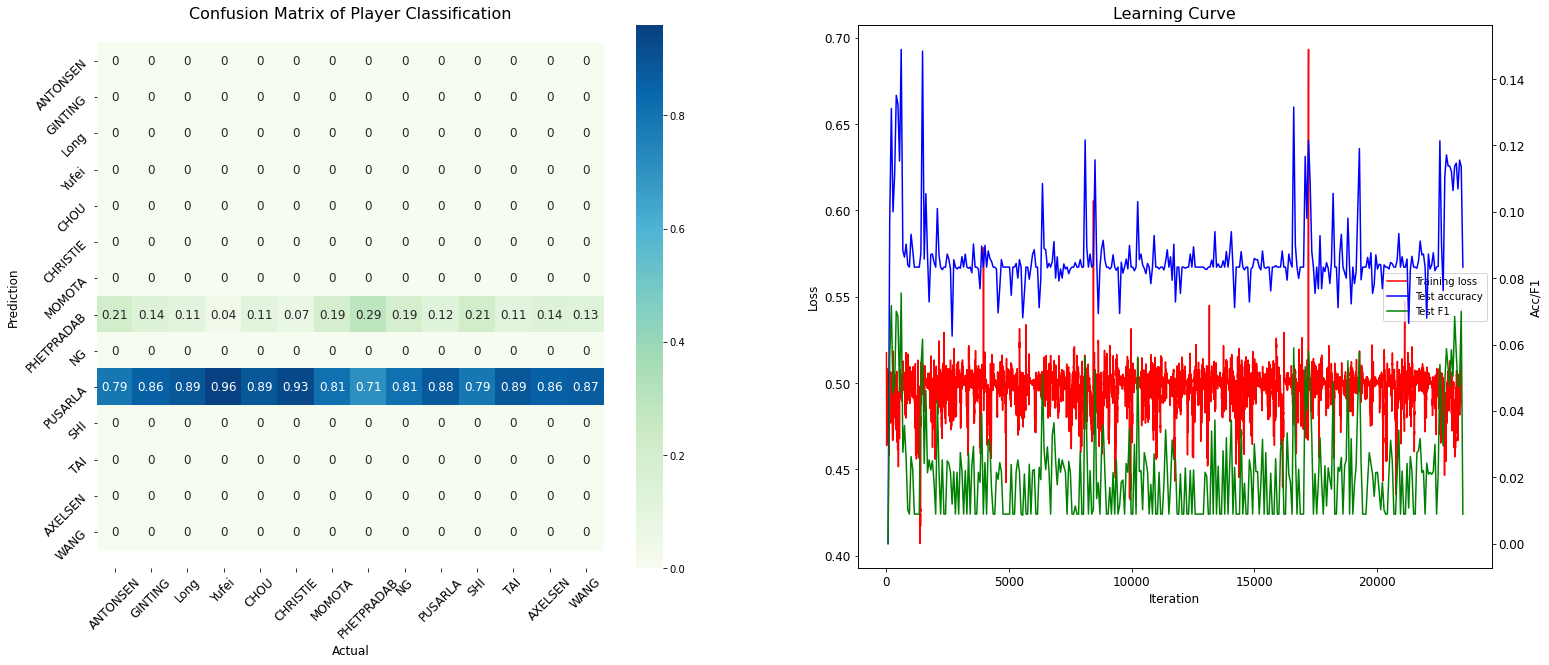

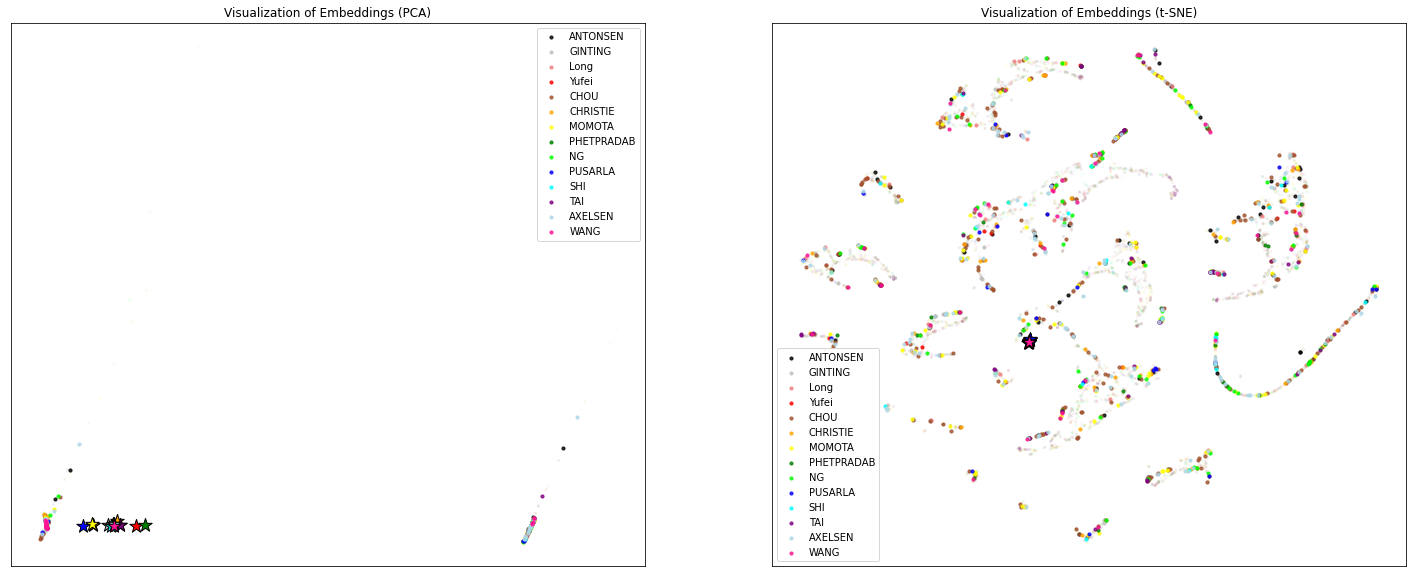

 75%|███████▍  | 374/500 [6:45:58<2:08:09, 61.02s/it]

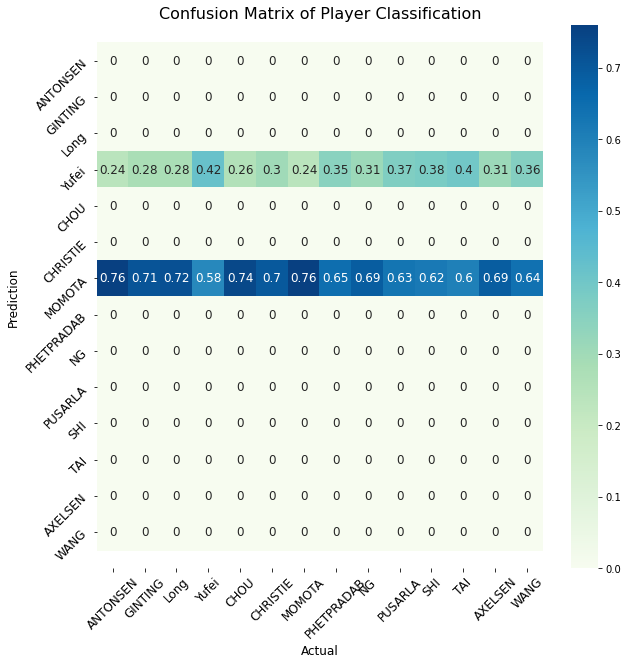

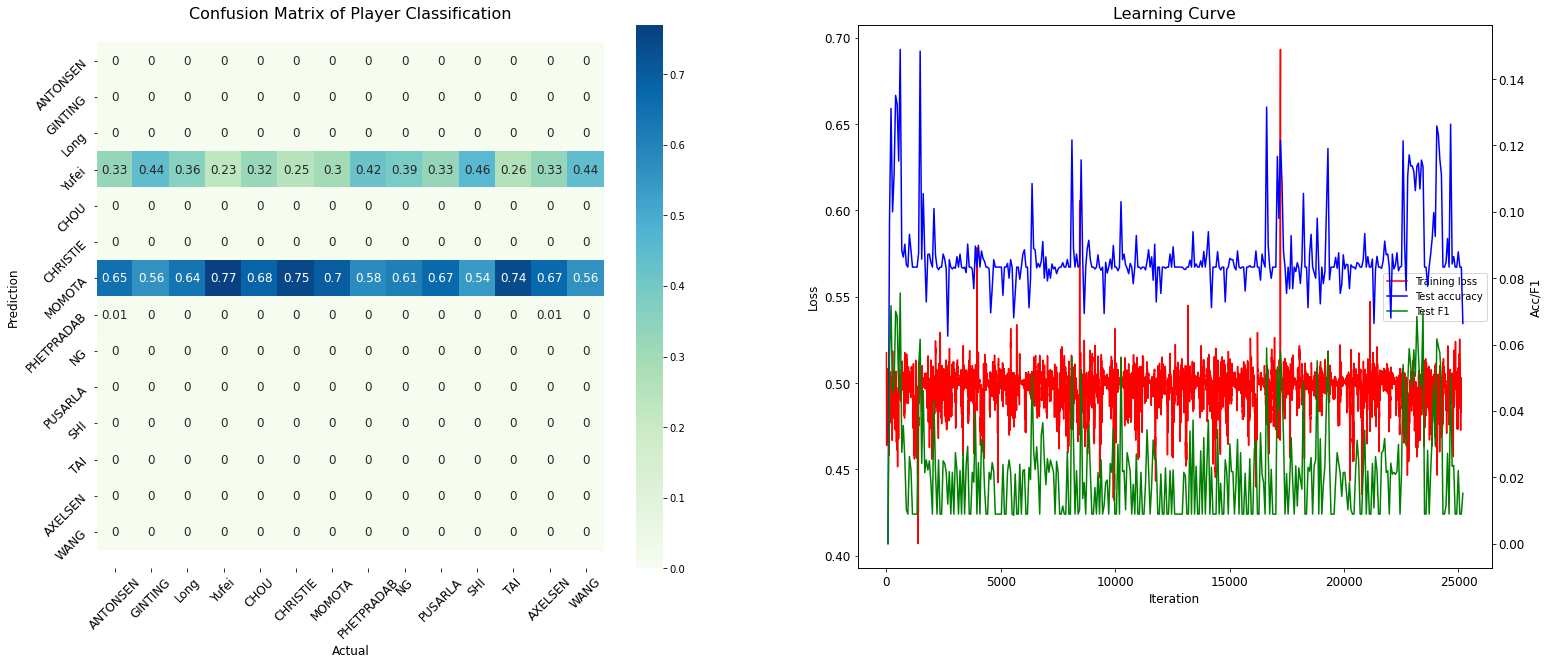

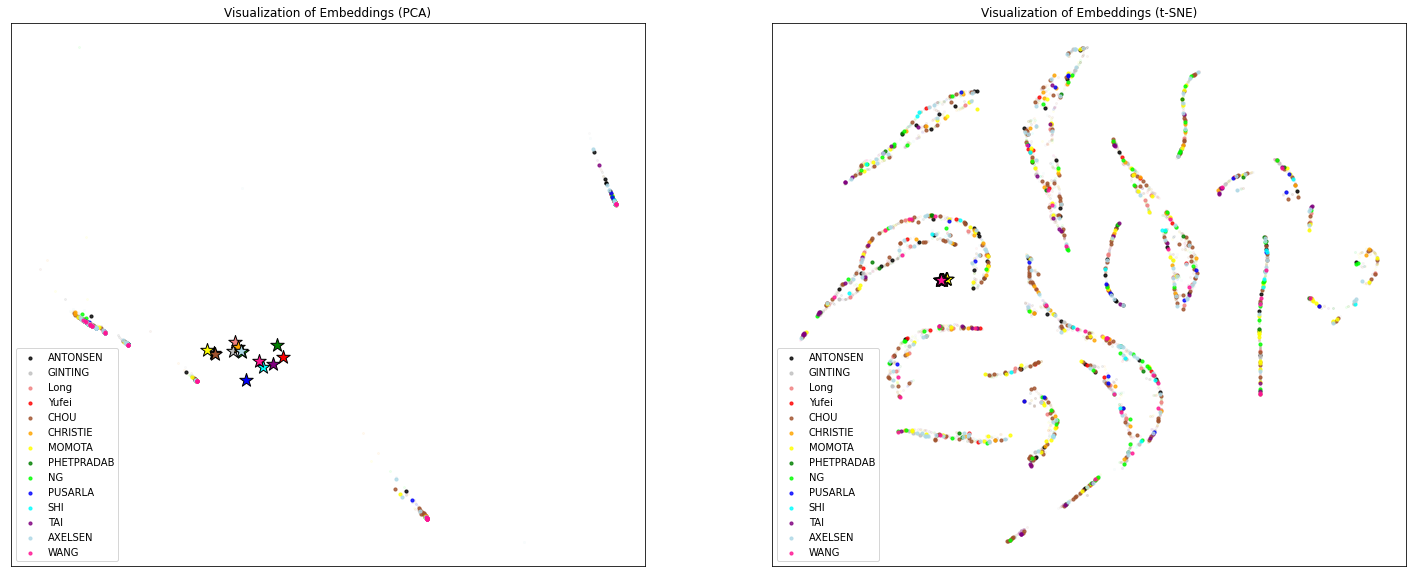

 80%|███████▉  | 399/500 [7:13:12<1:43:12, 61.31s/it]

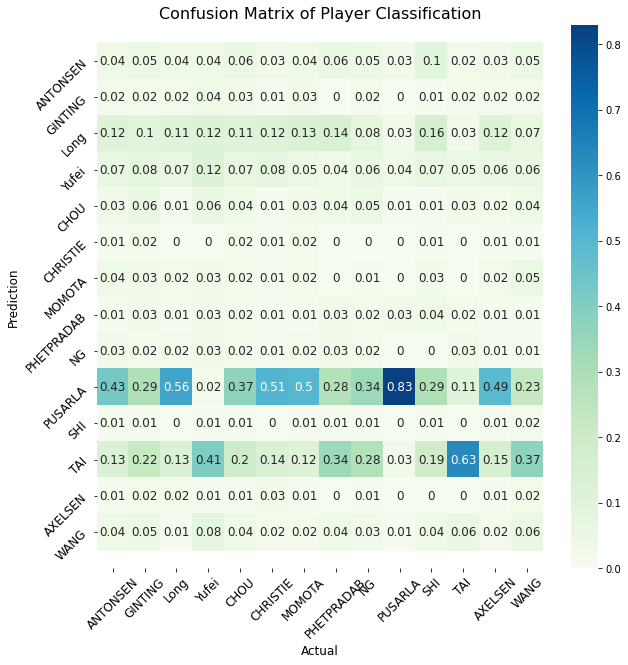

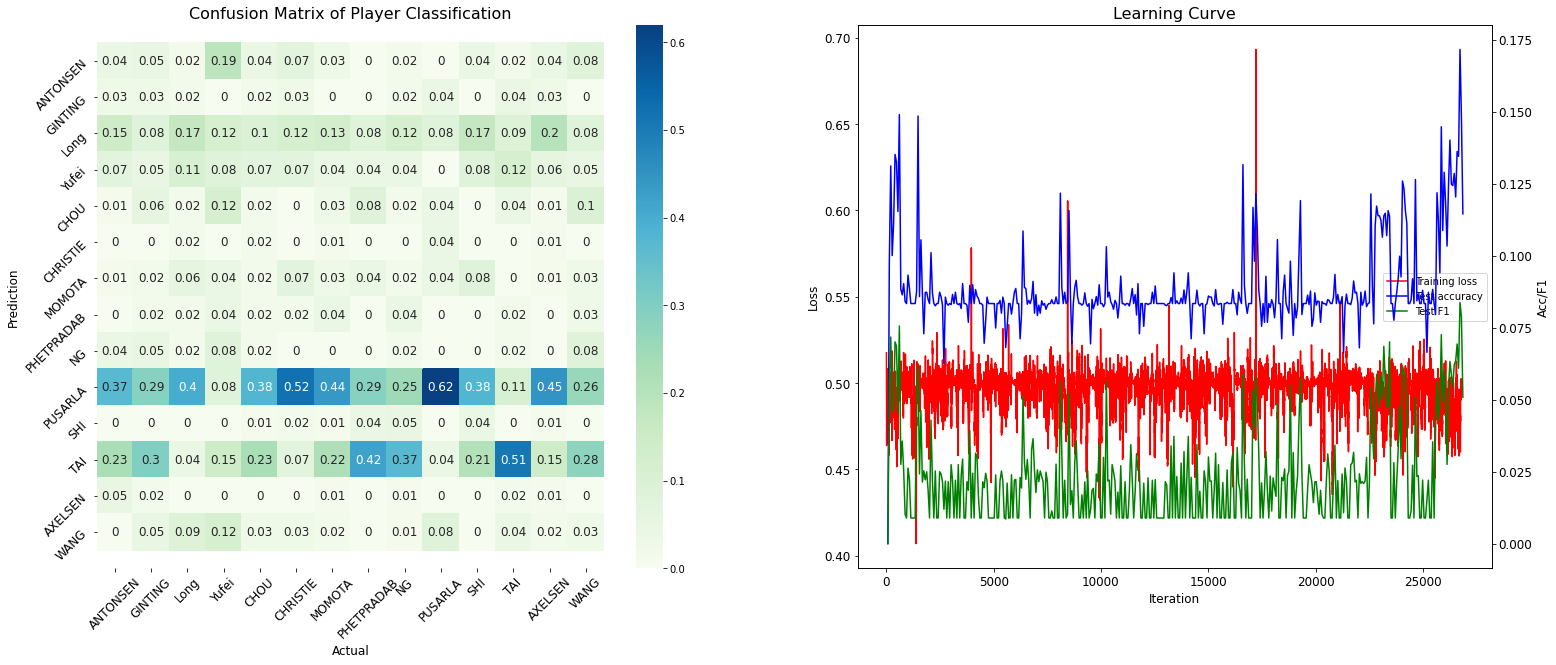

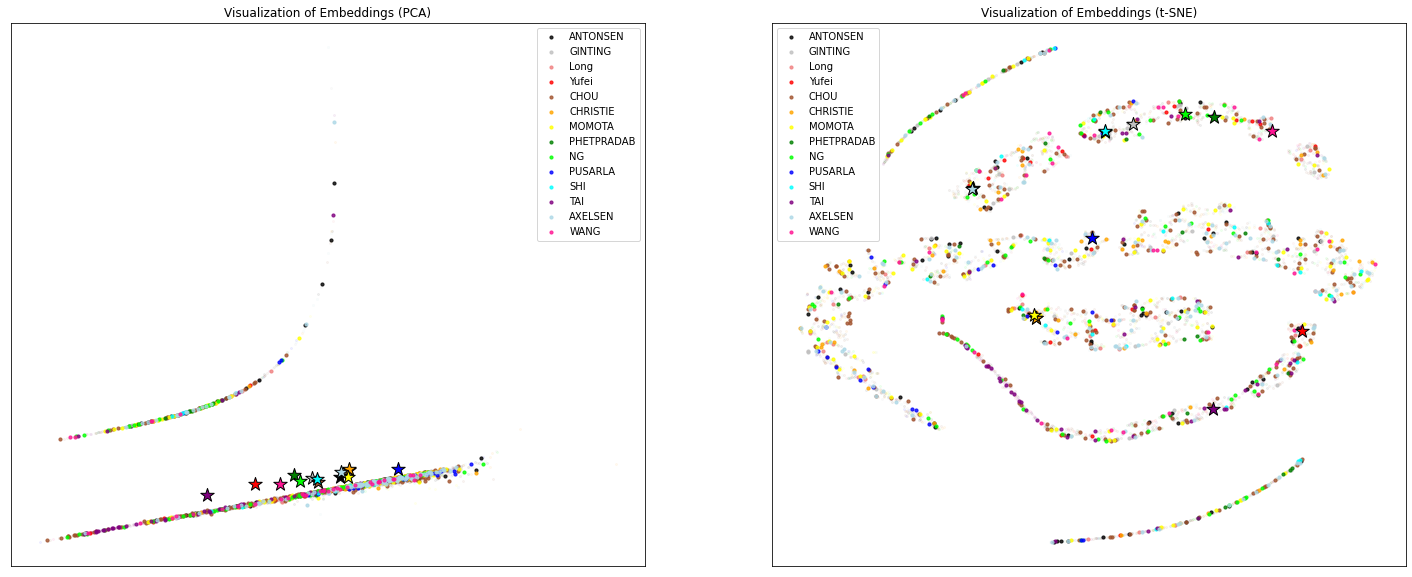

 85%|████████▍ | 424/500 [7:40:36<1:17:56, 61.54s/it]

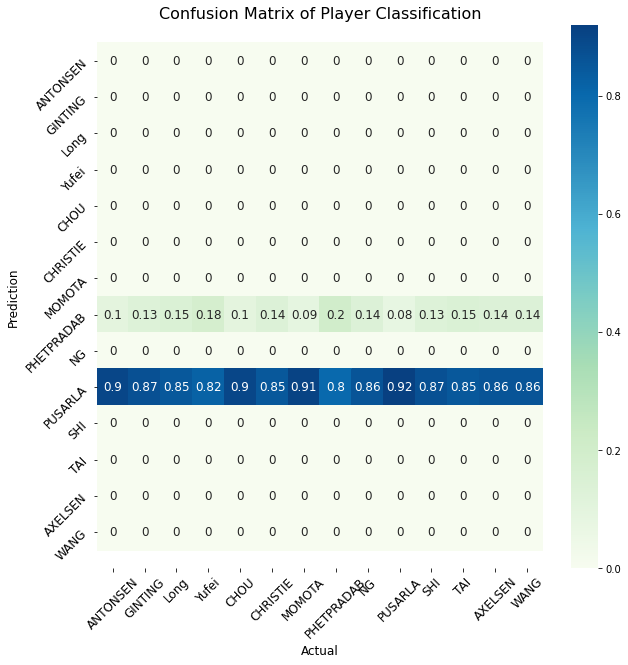

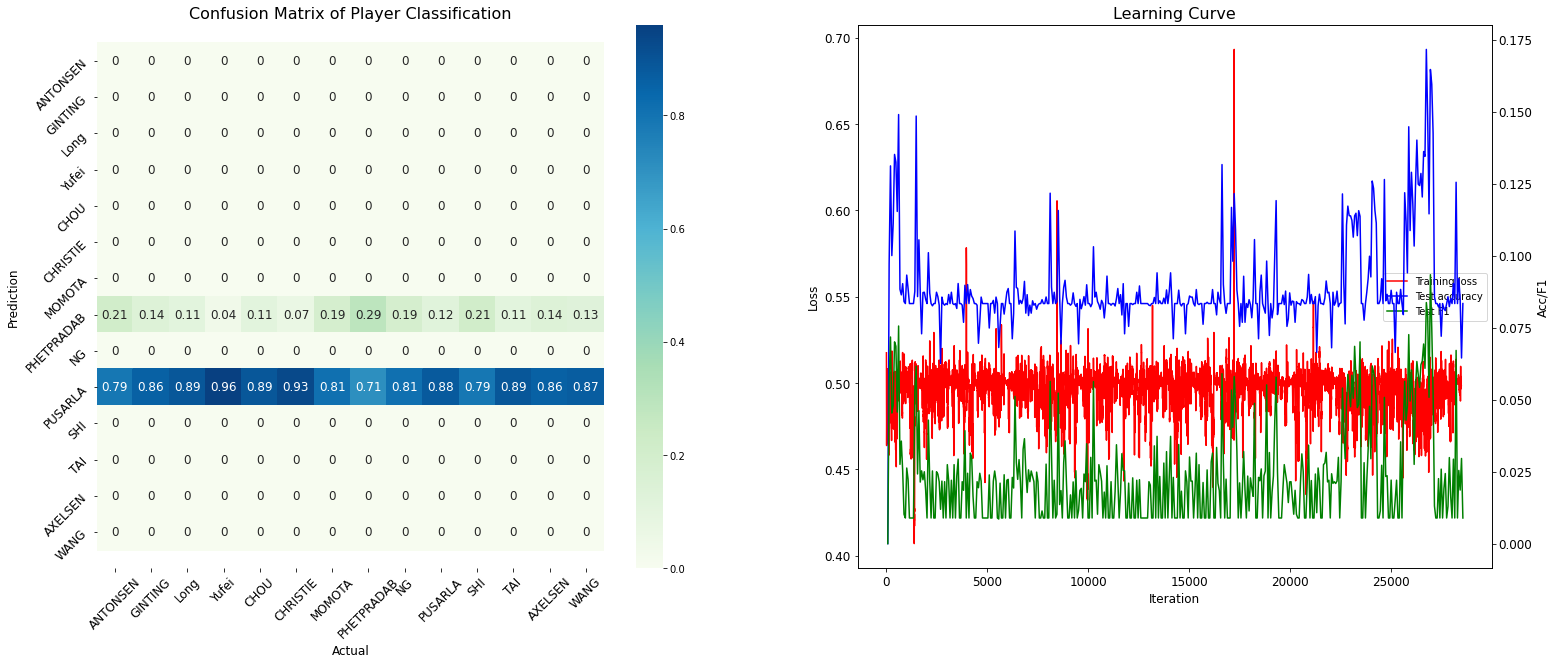

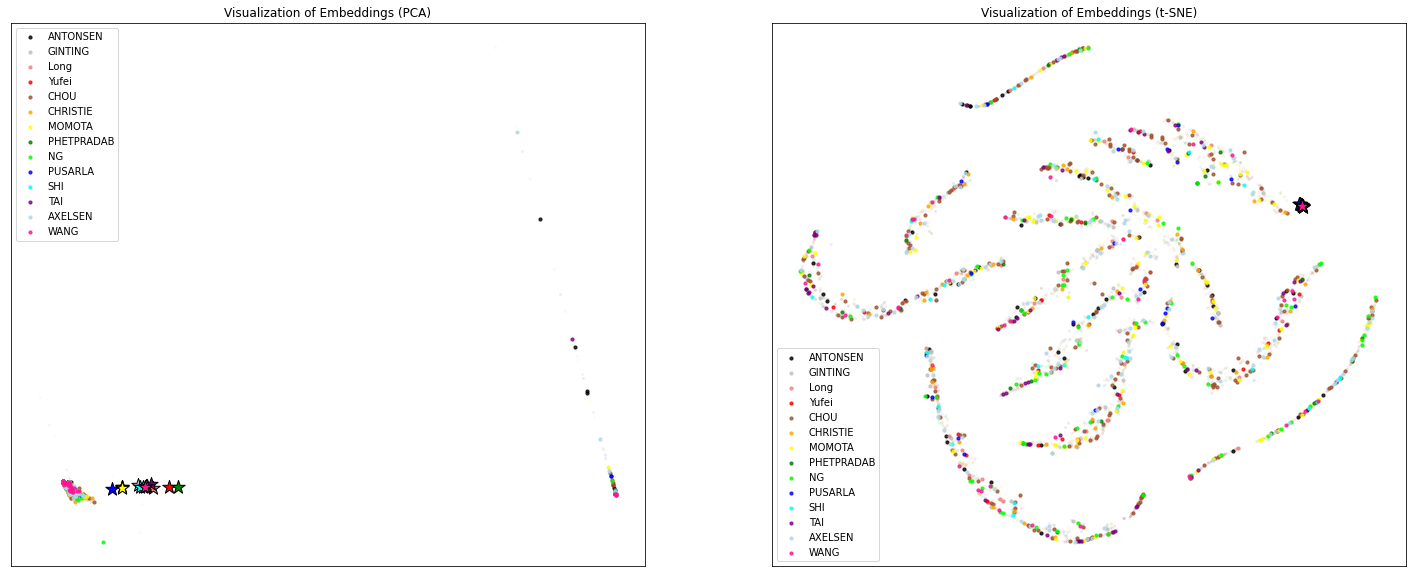

 90%|████████▉ | 449/500 [8:07:53<51:47, 60.94s/it]  

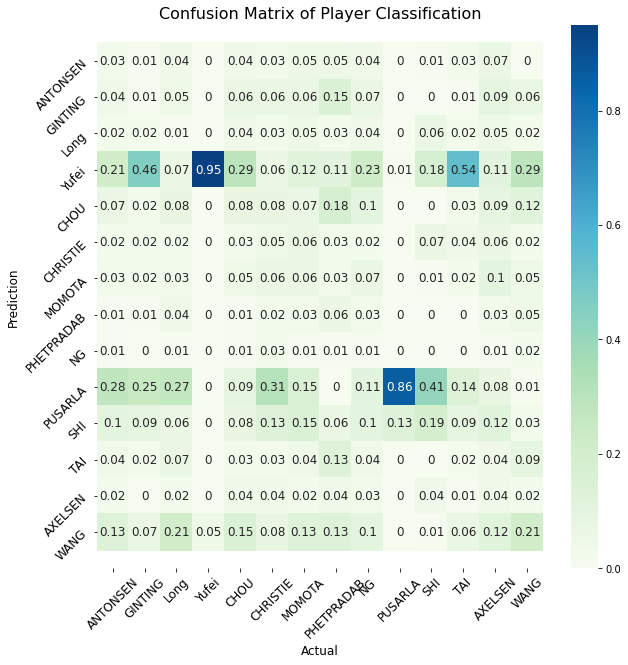

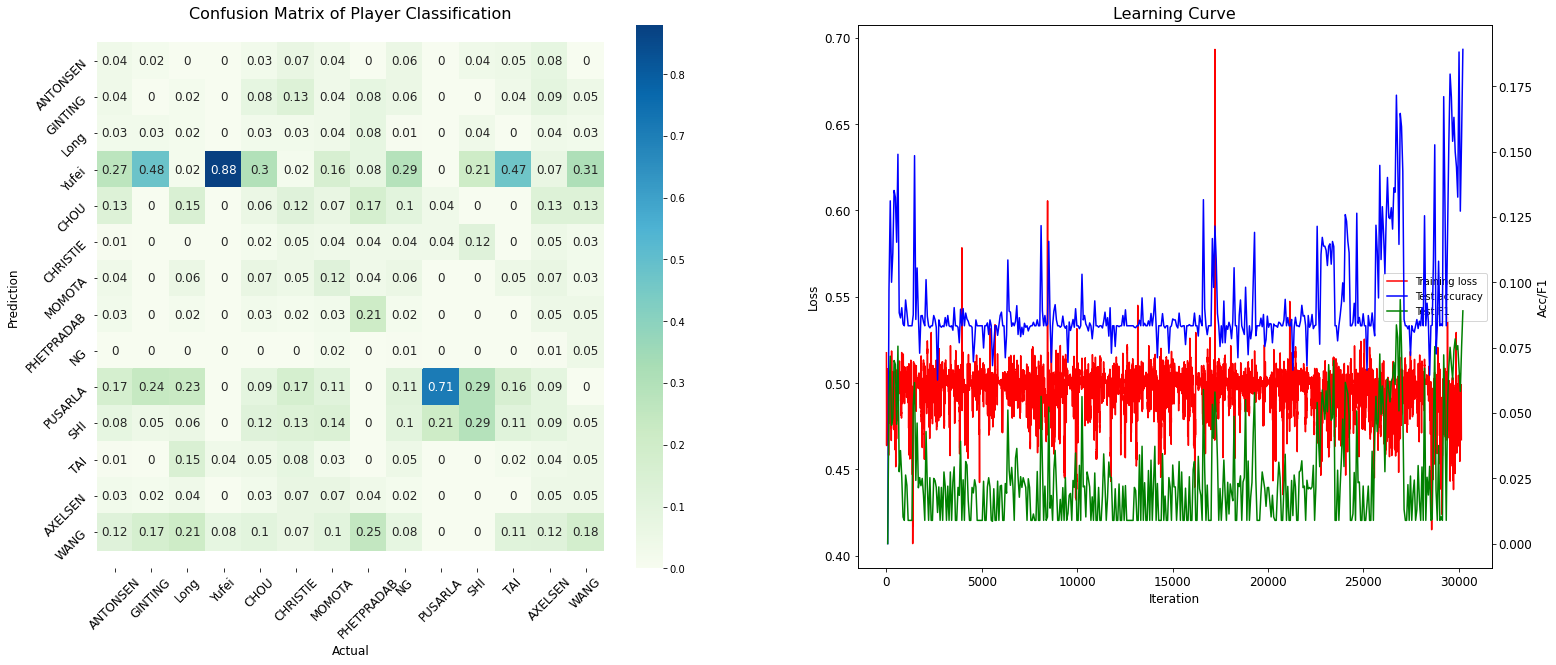

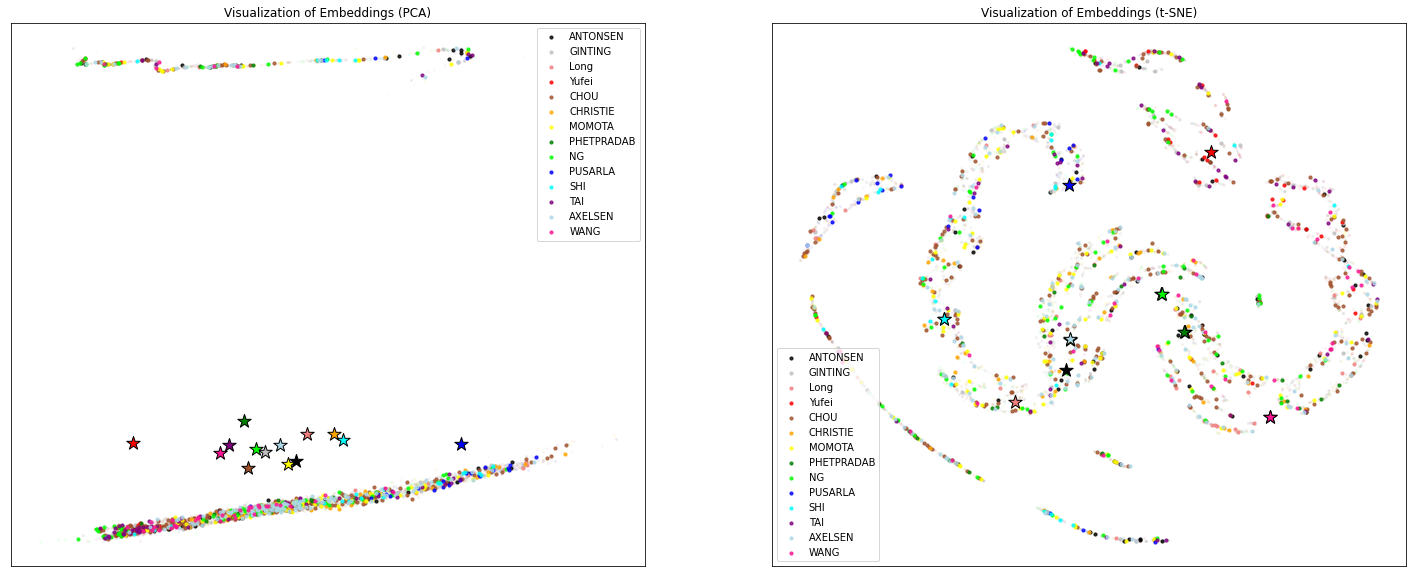

 95%|█████████▍| 474/500 [8:35:18<26:38, 61.49s/it]  

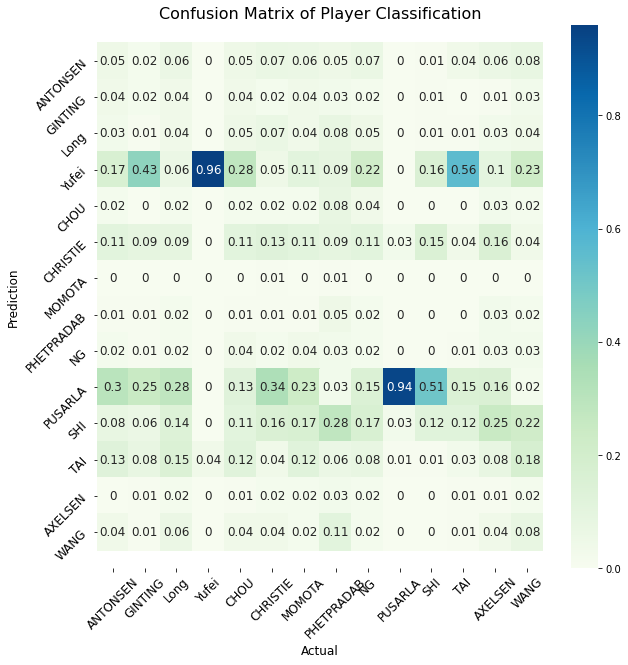

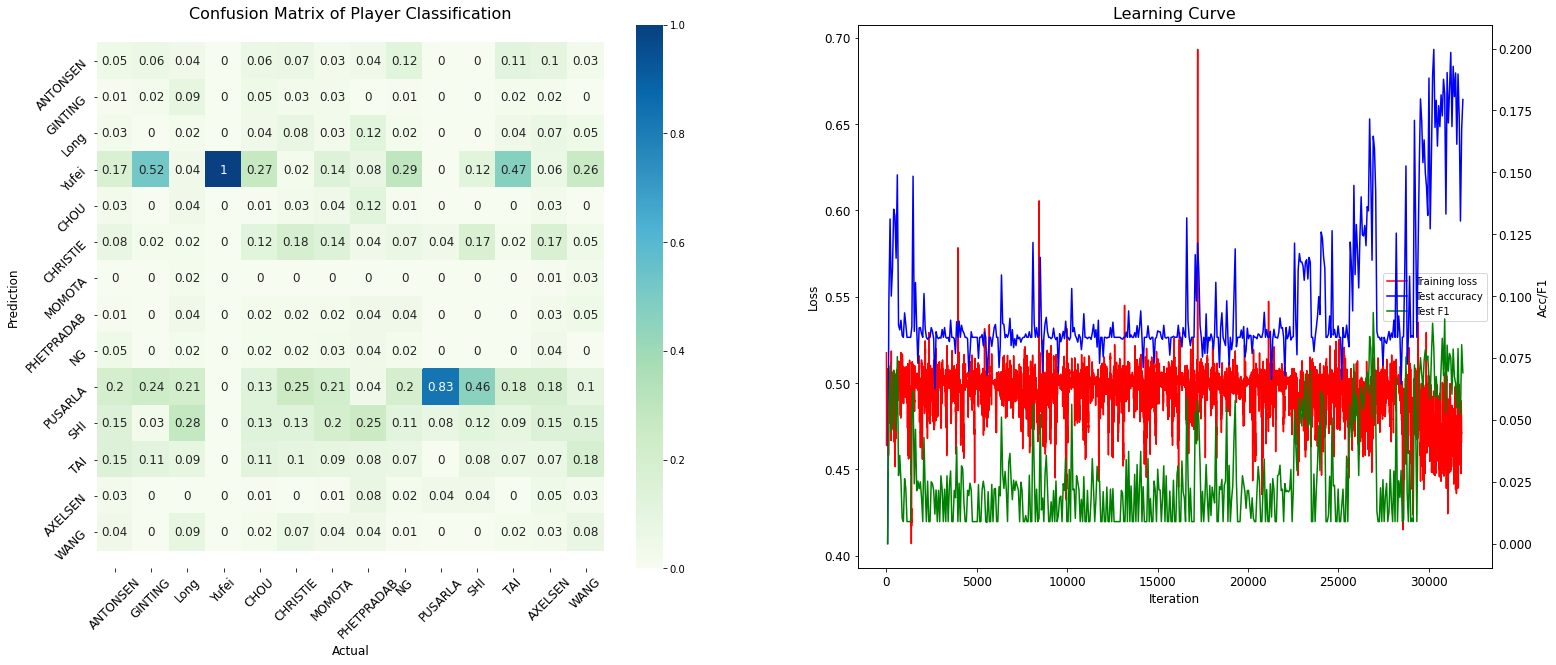

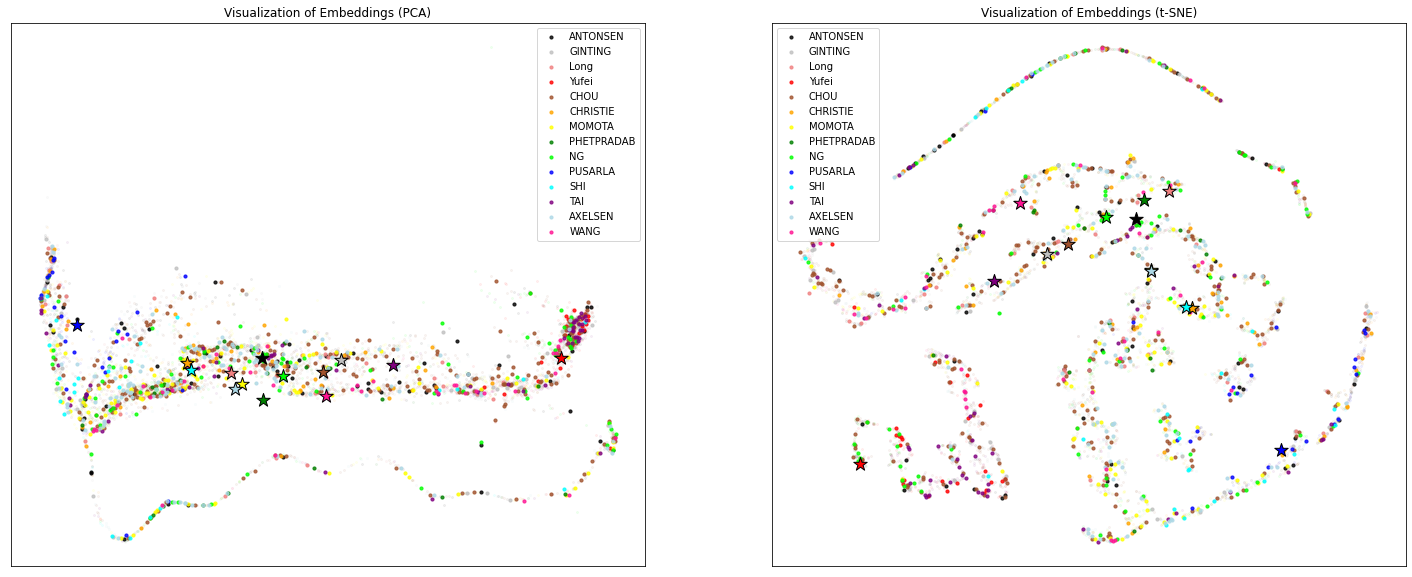

100%|█████████▉| 499/500 [9:02:43<01:01, 61.66s/it]

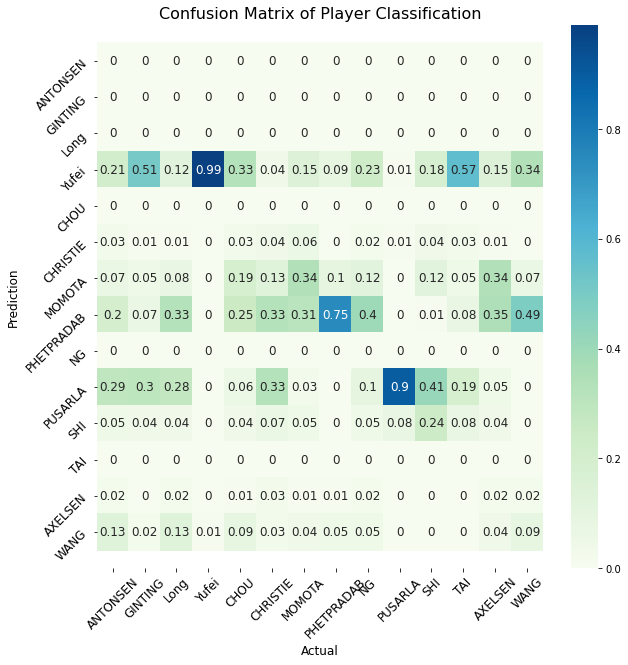

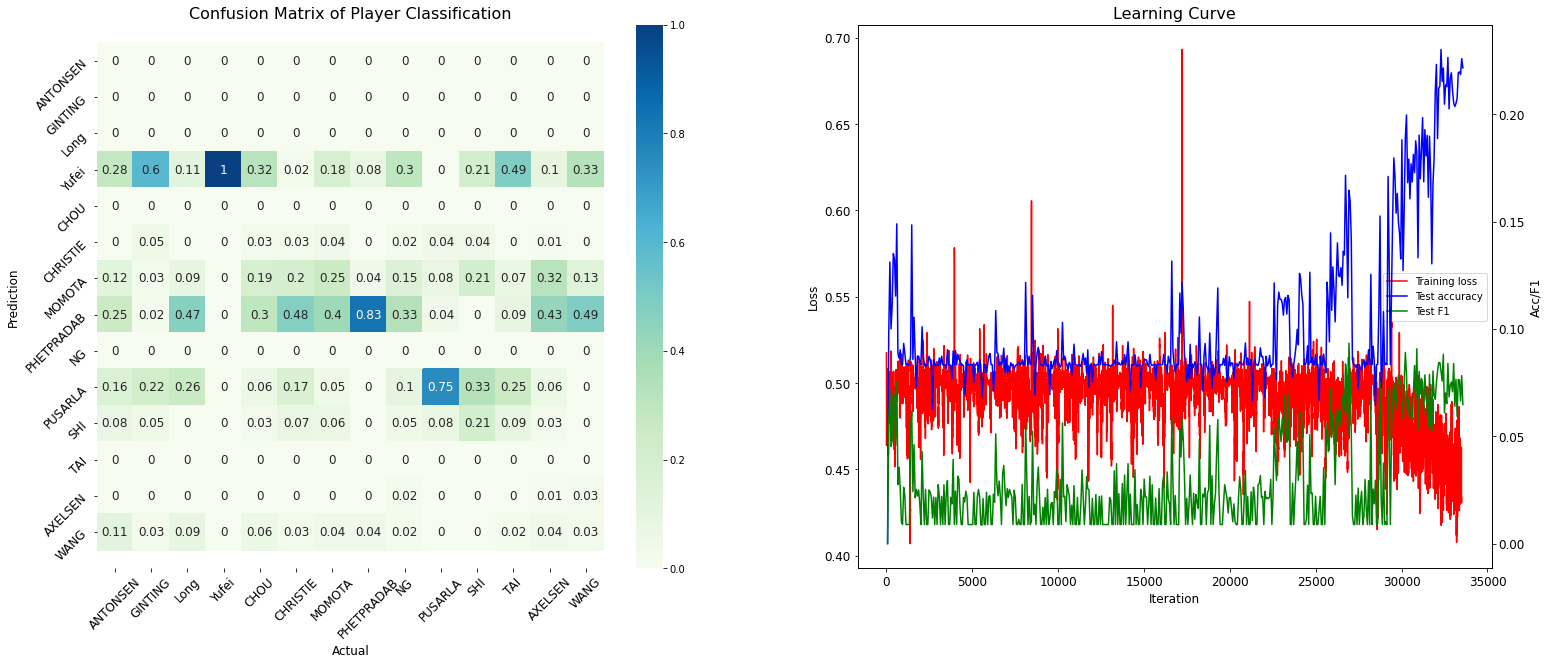

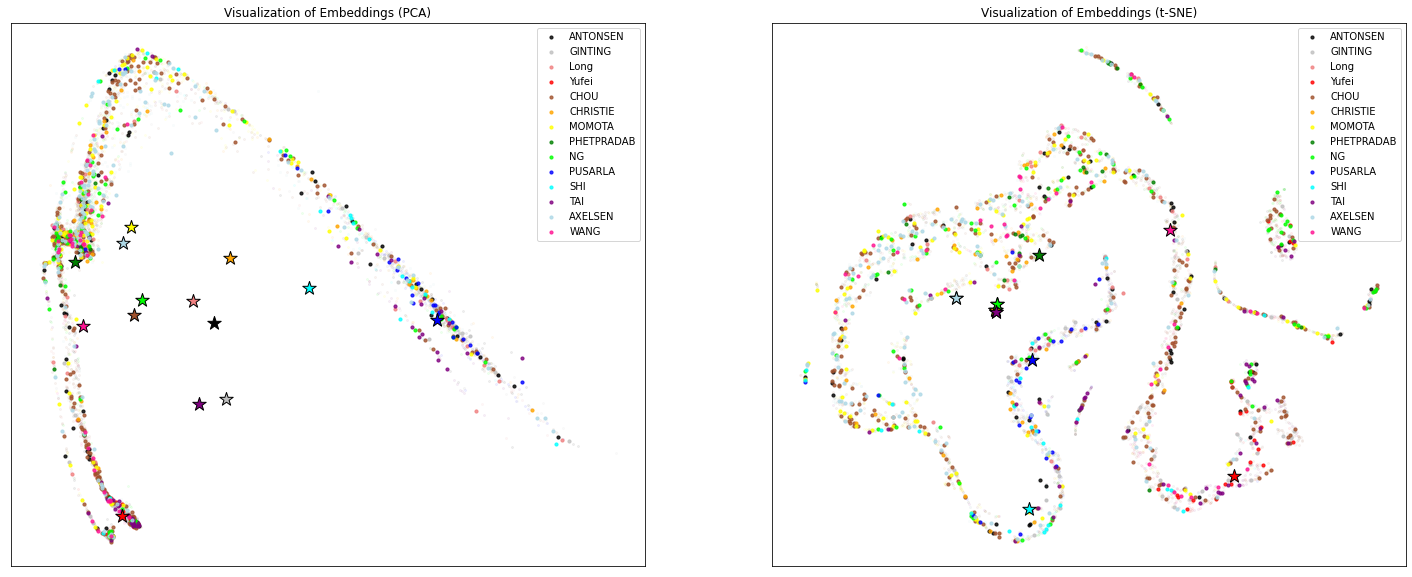

100%|██████████| 500/500 [9:05:31<00:00, 65.46s/it]


In [21]:
out = Output()
display.display(out)

losses = []
accs = [0]
f1s = [0]
gc.collect()

for epoch in tqdm(range(EPOCHS)):
    net.train()
    for idx, (anchor_target, anchor_opponent, positive_target, positive_opponent, negative_target, negative_opponent, anchor_target_len, anchor_opponent_len, positive_target_len, positive_opponent_len, negative_target_len, negative_opponent_len) in enumerate(trainloader):
        anchor_target, anchor_opponent = anchor_target.cuda(), anchor_opponent.cuda()
        positive_target, positive_opponent = positive_target.cuda(), positive_opponent.cuda()
        negative_target, negative_opponent = negative_target.cuda(), negative_opponent.cuda()
        optimizer.zero_grad()
        
        anchor_embedding = net(anchor_target, anchor_target_len, anchor_opponent, anchor_opponent_len)
        positive_embedding = net(positive_target, positive_target_len, positive_opponent, positive_opponent_len)
        negative_embedding = net(negative_target, negative_target_len, negative_opponent, negative_opponent_len)
        
        loss = triplet_loss(anchor_embedding, positive_embedding, negative_embedding)
        
        loss.backward()
        losses.append((loss).item())
        optimizer.step()

    if (epoch+1) % 25 == 0:
        train_embeddings, train_labels = generate_all_embedding(num_classes, hidden_dim, net, pc_loader)
        trainloader.dataset.update_distance(train_embeddings)
        test_embeddings, test_labels = generate_all_embedding(num_classes, hidden_dim, net, testloader)
        class_embedding = generate_class_embedding(num_classes, hidden_dim, net, pc_loader)
        with out:
            verify(net, class_embedding, verifyloader, num_classes, conf=True)
                        
            fig, axes = plt.subplots(1, 2, figsize=(25, 10))
            acc, f1 = validation(net, class_embedding, testloader, num_classes, epoch, axes[0], conf=True)
            accs.append(acc)
            f1s.append(f1)
            plots(losses, accs, f1s, 10, axes[1])
            plt.show()
            
            fig, axes = plt.subplots(1, 2, figsize=(25, 10))
            
            tsne_viz_train_test(train_embeddings.cpu().numpy(), train_labels, test_embeddings.cpu().numpy(), test_labels, class_embedding.cpu(), axes[0], 'pca')
            tsne_viz_train_test(train_embeddings.cpu().numpy(), train_labels, test_embeddings.cpu().numpy(), test_labels, class_embedding.cpu(), axes[1], 'tsne')
            plt.show()

    else:
        train_embeddings, train_labels = generate_all_embedding(num_classes, hidden_dim, net, pc_loader)
        trainloader.dataset.update_distance(train_embeddings)
        class_embedding = generate_class_embedding(num_classes, hidden_dim, net, pc_loader)
        acc, f1 = validation(net, class_embedding, testloader, num_classes, epoch, ax=None)
        accs.append(acc)
        f1s.append(f1)

In [22]:
torch.save(net.state_dict(), 'attention.pt')

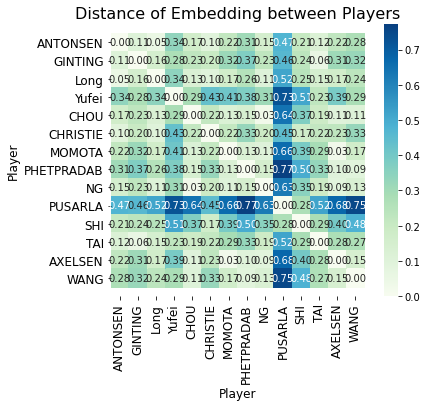

In [23]:
class_distance_viz(class_embedding, num_classes)

In [24]:
print('# discriminator parameters:', sum(param.numel() for param in net.parameters()))

# discriminator parameters: 168091662
